In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy

from scipy import stats

import pymc3 as pm

In [2]:
with pd.HDFStore("out/Training_2002_2005.h5") as store:
    print store
    df = store["first_author"]

<class 'pandas.io.pytables.HDFStore'>
File path: out/Training_2002_2005.h5
/first_author            frame        (shape->[41618369,56])


In [3]:
df.head()

,source_id,source_year,source_j,source_n_mesh,source_n_mesh_ex,source_is_eng,source_country,source_is_journal,source_is_review,source_is_case_rep,...,eth1,eth2,pos,pos_nice,sink_last_ncites,sink_prev_ncites,auth_last_npapers,auth_prev_papers,jj_sim,is_self_cite
0,16526454,2005,J AOAC Int,11,53,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,2,1,1,20,14.6053,0
1,16526454,2005,J AOAC Int,11,53,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,1,2,1,20,14.6053,1
2,14595765,2003,J Comp Neurol,17,71,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,5,8,1,7,0.0000,0
3,14595765,2003,J Comp Neurol,17,71,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,5,17,1,7,5.5691,0
4,14595765,2003,J Comp Neurol,17,71,1,JAPAN,1,0,0,...,JAPANESE,UNKNOWN,1,1,9,22,1,7,5.5691,0


In [4]:
df.columns

Index([u'source_id', u'source_year', u'source_j', u'source_n_mesh',
       u'source_n_mesh_ex', u'source_is_eng', u'source_country',
       u'source_is_journal', u'source_is_review', u'source_is_case_rep',
       u'source_is_let_ed_com', u'source_T_novelty', u'source_V_novelty',
       u'source_PT_novelty', u'source_PV_novelty', u'source_ncites',
       u'source_n_authors', u'sink_id', u'sink_year', u'sink_j',
       u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng', u'sink_is_journal',
       u'sink_is_review', u'sink_is_case_rep', u'sink_is_let_ed_com',
       u'sink_T_novelty', u'sink_V_novelty', u'sink_PT_novelty',
       u'sink_PV_novelty', u'sink_n_authors', u'year_span', u'journal_same',
       u'mesh_sim', u'title_sim', u'lang_sim', u'affiliation_sim',
       u'pubtype_sim', u'cite_sim', u'author_sim', u'gender_sim', u'eth_sim',
       u'n_common_authors', u'auid', u'gender', u'eth1', u'eth2', u'pos',
       u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_l

## Encode the weights of ethnicity

In [10]:
df["eth_weight"] = 0.5 # Partial weight to multi ethnicity
df.ix[df.eth2 == "UNKNOWN", "eth_weight"] = 1 # Ful weight to single ethnicity

In [11]:
df.head()

,source_id,source_year,source_j,source_n_mesh,source_n_mesh_ex,source_is_eng,source_country,source_is_journal,source_is_review,source_is_case_rep,...,eth2,pos,pos_nice,sink_last_ncites,sink_prev_ncites,auth_last_npapers,auth_prev_papers,jj_sim,is_self_cite,eth_weight
0,16526454,2005,J AOAC Int,11,53,1,JAPAN,1,0,0,...,UNKNOWN,1,1,2,1,1,20,14.6053,0,1.0
1,16526454,2005,J AOAC Int,11,53,1,JAPAN,1,0,0,...,UNKNOWN,1,1,1,2,1,20,14.6053,1,1.0
2,14595765,2003,J Comp Neurol,17,71,1,JAPAN,1,0,0,...,UNKNOWN,1,1,5,8,1,7,0.0000,0,1.0
3,14595765,2003,J Comp Neurol,17,71,1,JAPAN,1,0,0,...,UNKNOWN,1,1,5,17,1,7,5.5691,0,1.0
4,14595765,2003,J Comp Neurol,17,71,1,JAPAN,1,0,0,...,UNKNOWN,1,1,9,22,1,7,5.5691,0,1.0


## Top 15 countries in PUBMED using MapAffil

```
SELECT mapaffil_author, COUNT(PMID) as C FROM Country GROUP BY mapaffil_author ORDER BY C DESC LIMIT 50;
```


```
USA	5630449
-	5381526
UK	1258220
JAPAN	1093784
GERMANY	943164
FRANCE	683470
ITALY	596575
CANADA	535345
CHINA	445054
AUSTRALIA	338799
SPAIN	332491
NETHERLANDS	315492
SWEDEN	277981
INDIA	255261
SWITZERLAND	206675
```

In [12]:
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "SWITZERLAND"]

In [13]:
df.source_country = df.source_country.astype("category", categories=TOP_15_COUNTRIES, ordered=False).fillna(TOP_15_COUNTRIES[1])

In [14]:
df.source_country.head()

0    JAPAN
1    JAPAN
2    JAPAN
3    JAPAN
4    JAPAN
Name: source_country, dtype: category
Categories (15, object): [USA, UNKNOWN, UK, JAPAN, ..., NETHERLANDS, SWEDEN, INDIA, SWITZERLAND]

## Top ethnicities

Multiple ethnicities are given partial weight

Code
```
df_author = pd.read_csv("data/AuthorEthGender.txt", sep="\t")
df_author["eth_weight"] = df_author.Ethnea.str.split("-").apply(lambda x: 1. / len(x))
df_author[["eth1", "eth2"]] = df_author.Ethnea.str.split("-", expand=True)
t = pd.concat([df_author.groupby("eth1")["eth_weight"].sum(),
               df_author.groupby("eth2")["eth_weight"].sum()],
             axis=1).sum(axis=1)
t.sort_values(ascending=False)
```

```
ENGLISH       2782108.5
GERMAN         906626.0
HISPANIC       824886.5
CHINESE        733996.5
JAPANESE       729496.0
SLAV           600884.5
FRENCH         549123.5
ITALIAN        425322.0
INDIAN         312127.5
NORDIC         304026.0
ARAB           253439.5
DUTCH          213680.0
KOREAN         138553.5
ISRAELI        126600.5
TURKISH         84244.0
GREEK           74970.0
AFRICAN         68456.5
UNKNOWN         49239.0
HUNGARIAN       44897.0
THAI            32824.0
ROMANIAN        24788.0
BALTIC           8647.5
VIETNAMESE       5267.0
INDONESIAN       3043.5
CARIBBEAN        2002.5
TOOSHORT          626.0
MONGOLIAN         188.5
POLYNESIAN         85.0
ERROR              33.0
```

In [15]:
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "ISRAELI", "UNKNOWN"]


In [16]:
df.eth1 = df.eth1.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna(TOP_15_ETHNICITIES[-1])
df.eth2 = df.eth2.astype("category", categories=TOP_15_ETHNICITIES, ordered=False).fillna(TOP_15_ETHNICITIES[-1])

In [17]:
df[["eth1", "eth2"]].head()

,eth1,eth2
0,JAPANESE,UNKNOWN
1,JAPANESE,UNKNOWN
2,JAPANESE,UNKNOWN
3,JAPANESE,UNKNOWN
4,JAPANESE,UNKNOWN


In [18]:
df[["eth1", "eth2"]].dtypes

eth1    category
eth2    category
dtype: object

In [19]:
df.gender.head()

0    M
1    M
2    M
3    M
4    M
Name: gender, dtype: object

In [20]:
GENDERS = ["-", "F", "M"]

In [21]:
df.gender = df.gender.astype("category", categories=GENDERS, ordered=False).fillna(GENDERS[0])

In [22]:
df.gender.head()

0    M
1    M
2    M
3    M
4    M
Name: gender, dtype: category
Categories (3, object): [-, F, M]

In [23]:
df.dtypes

source_id                  int64
source_year                int64
source_j                  object
source_n_mesh              int64
source_n_mesh_ex           int64
source_is_eng              int64
source_country          category
source_is_journal          int64
source_is_review           int64
source_is_case_rep         int64
source_is_let_ed_com       int64
source_T_novelty         float64
source_V_novelty         float64
source_PT_novelty        float64
source_PV_novelty        float64
source_ncites              int64
source_n_authors           int64
sink_id                    int64
sink_year                  int64
sink_j                    object
sink_n_mesh                int64
sink_n_mesh_ex             int64
sink_is_eng                int64
sink_is_journal            int64
sink_is_review             int64
sink_is_case_rep           int64
sink_is_let_ed_com         int64
sink_T_novelty           float64
sink_V_novelty           float64
sink_PT_novelty          float64
sink_PV_no

In [24]:
df_skimmed = df.drop(["source_j", "sink_j", "auid"], axis=1)

In [25]:
with pd.HDFStore('out/ModelData.h5') as cstore:
    cstore.append('first_author', df_skimmed, format='table', data_columns=['source_country','gender', 'eth1', 'eth2'])

## Load data from HDF5

In [2]:
with pd.HDFStore('out/ModelData.h5') as cstore:
    df = cstore['first_author']

In [3]:
df.head()

,source_id,source_year,source_n_mesh,source_n_mesh_ex,source_is_eng,source_country,source_is_journal,source_is_review,source_is_case_rep,source_is_let_ed_com,...,eth2,pos,pos_nice,sink_last_ncites,sink_prev_ncites,auth_last_npapers,auth_prev_papers,jj_sim,is_self_cite,eth_weight
0,16526454,2005,11,53,1,JAPAN,1,0,0,0,...,UNKNOWN,1,1,2,1,1,20,14.6053,0,1.0
1,16526454,2005,11,53,1,JAPAN,1,0,0,0,...,UNKNOWN,1,1,1,2,1,20,14.6053,1,1.0
2,14595765,2003,17,71,1,JAPAN,1,0,0,0,...,UNKNOWN,1,1,5,8,1,7,0.0000,0,1.0
3,14595765,2003,17,71,1,JAPAN,1,0,0,0,...,UNKNOWN,1,1,5,17,1,7,5.5691,0,1.0
4,14595765,2003,17,71,1,JAPAN,1,0,0,0,...,UNKNOWN,1,1,9,22,1,7,5.5691,0,1.0


## Models

In [4]:
GENDERS = ["-", "F", "M"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "ISRAELI", "UNKNOWN"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "SWITZERLAND"]

In [5]:
df.columns

Index([u'source_id', u'source_year', u'source_n_mesh', u'source_n_mesh_ex',
       u'source_is_eng', u'source_country', u'source_is_journal',
       u'source_is_review', u'source_is_case_rep', u'source_is_let_ed_com',
       u'source_T_novelty', u'source_V_novelty', u'source_PT_novelty',
       u'source_PV_novelty', u'source_ncites', u'source_n_authors', u'sink_id',
       u'sink_year', u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng',
       u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
       u'sink_is_let_ed_com', u'sink_T_novelty', u'sink_V_novelty',
       u'sink_PT_novelty', u'sink_PV_novelty', u'sink_n_authors', u'year_span',
       u'journal_same', u'mesh_sim', u'title_sim', u'lang_sim',
       u'affiliation_sim', u'pubtype_sim', u'cite_sim', u'author_sim',
       u'gender_sim', u'eth_sim', u'n_common_authors', u'gender', u'eth1',
       u'eth2', u'pos', u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_last_npapers', u'auth_prev_papers', u'jj_

In [6]:
## Change dtype of comparisons to boolean
## Make sure is_self_cite is not set to bool. Change its values in the resulting files as well.

df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']] = df[[u'source_is_eng', u'source_is_journal', u'source_is_review',
    u'source_is_case_rep', u'source_is_let_ed_com',
    u'sink_is_eng', u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
    u'sink_is_let_ed_com', u'journal_same', u'affiliation_sim']].astype("bool")

In [15]:
%load_ext autoreload

In [73]:
%autoreload 2

MF reloaded2


In [31]:
import model_functions as mf

In [74]:
mf.MC(df.eth1.head(), df.eth2.head(), weights=df.eth_weight.head(), levels=TOP_15_ETHNICITIES)

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


,T.ISRAELI,T.CHINESE,T.GERMAN,T.UNKNOWN,T.DUTCH,T.JAPANESE,T.FRENCH,T.SLAV,T.HISPANIC,T.INDIAN,T.NORDIC,T.ENGLISH,T.KOREAN,T.ITALIAN
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
formula = ("is_self_cite ~ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)")
y,X = patsy.dmatrices(formula, data=df.head(10000), return_type="dataframe")

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w


In [52]:
X.head(1000)[np.any(X.head(1000) == 0.5, axis=1)].head()

,Intercept,"mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[7]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[8]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[9]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[10]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[11]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[12]","mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[13]"
102,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
103,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
104,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
105,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
106,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0


In [12]:
np.where(np.array(df.eth1.head()) == "JAPANESE")

(array([0, 1, 2, 3, 4]),)

In [13]:
df.eth_weight.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: eth_weight, dtype: float64

In [53]:
formula = ("is_self_cite ~ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)")
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
model = Logit(y,X)
res = model.fit()
res.summary2()

using complimentary weights for 2 columns. w and 1-w
using complimentary weights for 2 columns. w and 1-w
Optimization terminated successfully.
         Current function value: 0.193507
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: Logit
=======================================================================================================================
Model:                               Logit                             Pseudo R-squared:                  0.003        
Dependent Variable:                  is_self_cite                      AIC:                               16106952.2967
Date:                                2016-05-18 14:20                  BIC:                               16107185.4575
No. Observations:                    41618369                          Log-Likelihood:                    -8.0535e+06  
Df Model:                            14                                LL-Null:                           -8.0787e+06  
Df Residuals:                        41618354                          LLR p-value:                       0.0000       
Converged:                           1.0000                            Scale:                             1.0000       
No. Iterations:                      7.0000                                                                            
-----------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                                            -2.8980   0.0013 -2233.3801 0.0000 -2.9006 -2.8955
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0]  -0.0041   0.0026    -1.5790 0.1143 -0.0091  0.0010
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1]  -0.2108   0.0032   -66.5090 0.0000 -0.2170 -0.2046
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2]  -0.3928   0.0031  -127.3322 0.0000 -0.3988 -0.3867
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3]   0.0676   0.0027    24.7066 0.0000  0.0622  0.0730
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4]  -0.0529   0.0040   -13.1842 0.0000 -0.0607 -0.0450
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5]  -0.1531   0.0032   -48.2244 0.0000 -0.1593 -0.1468
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6]   0.1349   0.0032    42.1778 0.0000  0.1286  0.1411
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[7]  -0.3675   0.0044   -83.7728 0.0000 -0.3761 -0.3589
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[8]   0.0879   0.0037    23.5952 0.0000  0.0806  0.0951
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[9]  -0.4196   0.0055   -76.5645 0.0000 -0.4304 -0.4089
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[10] -0.0168   0.0044    -3.8472 0.0001 -0.0254 -0.0082
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[11] -0.6043   0.0066   -91.4098 0.0000 -0.6172 -0.5913
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[12] -0.0631   0.0067    -9.4883 0.0000 -0.0762 -0.0501
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[13] -0.3567   0.0152   -23.3991 0.0000 -0.3865 -0.3268
=======================================================================================================================

"""

In [55]:
formula = ("is_self_cite ~ I(auth_prev_papers == 0) + np.log10(auth_prev_papers + 1)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites) + np.log10(source_n_authors)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span)"
           "+ np.log10(jj_sim + 1) + journal_same + np.log10(sink_prev_ncites + 1)"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
          )
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
model = Logit(y,X)
res = model.fit()
res.summary2()

using complimentary weights for 2 columns. w and 1-w
using complimentary weights for 2 columns. w and 1-w
Optimization terminated successfully.
         Current function value: 0.153904
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: Logit
======================================================================================================================
Model:                                Logit                            Pseudo R-squared:                 0.207        
Dependent Variable:                   is_self_cite                     AIC:                              12810597.3607
Date:                                 2016-05-18 16:27                 BIC:                              12811452.2836
No. Observations:                     41618369                         Log-Likelihood:                   -6.4052e+06  
Df Model:                             54                               LL-Null:                          -8.0787e+06  
Df Residuals:                         41618314                         LLR p-value:                      0.0000       
Converged:                            1.0000                           Scale:                            1.0000       
No. Iterations:                       10.0000                                                                         
----------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                                            -2.4341   0.0222 -109.8333 0.0000 -2.4775 -2.3907
I(auth_prev_papers == 0)[T.True]                                     -1.5314   0.0080 -191.5344 0.0000 -1.5471 -1.5157
C(gender, levels=GENDERS)[T.F]                                       -0.0105   0.0033   -3.1562 0.0016 -0.0170 -0.0040
C(gender, levels=GENDERS)[T.M]                                       -0.0323   0.0031  -10.5348 0.0000 -0.0383 -0.0263
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.0972   0.0025  -38.2010 0.0000 -0.1022 -0.0922
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                      0.0015   0.0032    0.4778 0.6328 -0.0048  0.0079
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.2450   0.0063   38.8582 0.0000  0.2327  0.2574
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 0.0181   0.0042    4.3447 0.0000  0.0099  0.0263
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.0439   0.0053   -8.3500 0.0000 -0.0542 -0.0336
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                  -0.1037   0.0065  -15.8843 0.0000 -0.1165 -0.0909
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.0049   0.0042   -1.1585 0.2466 -0.0132  0.0034
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.4479   0.0099  -45.1007 0.0000 -0.4674 -0.4285
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               0.1006   0.0052   19.2761 0.0000  0.0904  0.1109
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                  -0.1301   0.0063  -20.5954 0.0000 -0.1425 -0.1177
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             0.0468   0.0071    6.5823 0.0000  0.0329  0.0608
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  0.0753   0.0067   11.2817 0.0000  0.0622  0.0884
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.0599   0.0105   -5.7319 0.0000 -0.0804 -0.0394
C(source_country, levels=TOP_15_COUNTRIES)[T.SWITZERLAND]            -0.0426   0.0069   -6.1393 0.0000 -0.0562 -0.0290
I(source_n_mesh_ex == 0)[T.True]                                     -0.1193   0.0106  -11.2447 0.0000 -0.1402 -0.0985
I(sink_n_mesh_ex == 0)[T.True]                                        0.1451   0.0105   13.7579 0.0000  0.1244  0.1658
I(year_span < 0)[T.True]                                             -1.2871

In [58]:
np.exp(res.params[res.params.index.str.startswith("mf.MC")])

mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0]     1.026087
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1]     1.104756
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2]     1.106784
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3]     0.964687
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4]     1.106321
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5]     0.963784
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6]     0.971974
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[7]     0.970077
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[8]     1.191427
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[9]     0.979502
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[10]    1.077937
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[11]    0.882891
mf.MC(eth1, eth2, weights=et

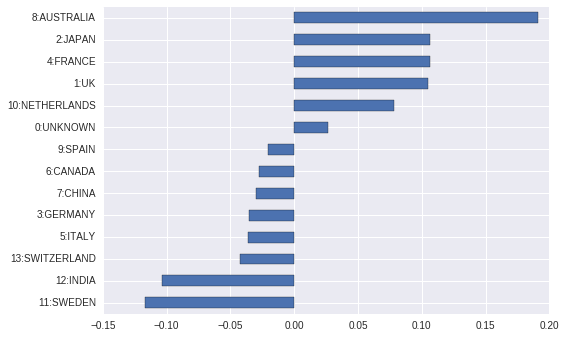

In [76]:
t = np.exp(res.params[res.params.index.str.startswith("mf.MC")]) - 1
t.index = ["%s:%s" % (i,k) for i,k in enumerate(TOP_15_COUNTRIES[1:])]
t.sort_values().plot(kind="barh")
#plt.gca().set_yticklabels(TOP_15_COUNTRIES[1:])

In [59]:
np.exp(res.params[res.params.index.str.startswith("C(source_country")])

C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]        0.907362
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]             1.001549
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]          1.277649
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]        1.018265
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]         0.957021
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]          0.901509
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]         0.995098
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]          0.638943
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]      1.105881
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]          0.878005
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]    1.047940
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]         1.078202
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]          0.941859
C(source_country, levels=TOP_15_COUNTRIES)[T.SWITZERLAND]    0.958312
dtype: float64

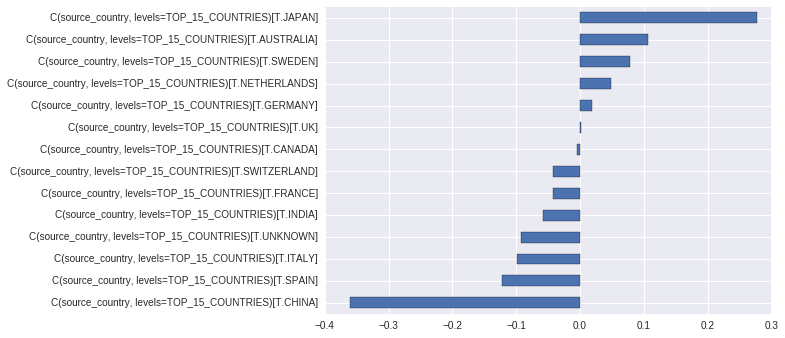

In [77]:
(np.exp(res.params[res.params.index.str.startswith("C(source_country")]) - 1).sort_values().plot(kind="barh")

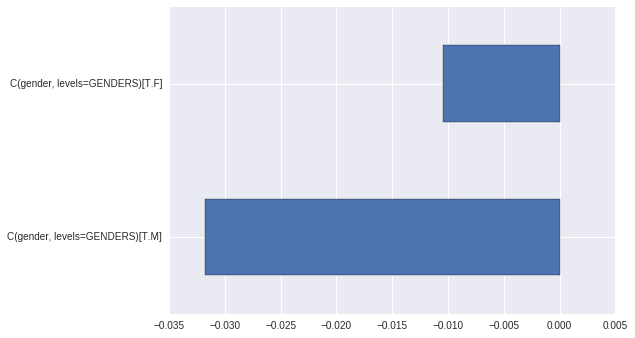

In [78]:
(np.exp(res.params[res.params.index.str.startswith("C(gender")]) - 1).sort_values().plot(kind="barh")

In [79]:
def logit(p):
    return np.log(p/(1-p))


def get_empirical_logit(df, X_col, y_col, conditioning_var="Gender",
    bins=None, testing=False, clip=(-3,3)):
    if testing:
        # If testing the just print X and y columns
        print X_col, y_col
        return conditioning_var, ({"llf": 0.1}, "TEMP SUMMARY")
    ## Not testing. Fit the models and return the measures
    print X_col, conditioning_var, y_col
    t = df.pivot_table(index=pd.cut(df[X_col], bins=bins),
      columns=conditioning_var, values=y_col,
      aggfunc=[np.mean, len])
    t = t.set_index(bins[1:])
    return t


In [80]:
df.columns

Index([u'source_id', u'source_year', u'source_n_mesh', u'source_n_mesh_ex',
       u'source_is_eng', u'source_country', u'source_is_journal',
       u'source_is_review', u'source_is_case_rep', u'source_is_let_ed_com',
       u'source_T_novelty', u'source_V_novelty', u'source_PT_novelty',
       u'source_PV_novelty', u'source_ncites', u'source_n_authors', u'sink_id',
       u'sink_year', u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng',
       u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
       u'sink_is_let_ed_com', u'sink_T_novelty', u'sink_V_novelty',
       u'sink_PT_novelty', u'sink_PV_novelty', u'sink_n_authors', u'year_span',
       u'journal_same', u'mesh_sim', u'title_sim', u'lang_sim',
       u'affiliation_sim', u'pubtype_sim', u'cite_sim', u'author_sim',
       u'gender_sim', u'eth_sim', u'n_common_authors', u'gender', u'eth1',
       u'eth2', u'pos', u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_last_npapers', u'auth_prev_papers', u'jj_

In [87]:
sns.set_context("poster")
sns.set_style("ticks")

auth_prev_papers
auth_prev_papers gender is_self_cite
sink_prev_ncites
sink_prev_ncites gender is_self_cite
source_n_mesh_ex
source_n_mesh_ex gender is_self_cite
sink_n_mesh_ex
sink_n_mesh_ex gender is_self_cite
jj_sim
jj_sim gender is_self_cite
year_span
year_span gender is_self_cite
source_ncites
source_ncites gender is_self_cite
source_n_authors
source_n_authors gender is_self_cite


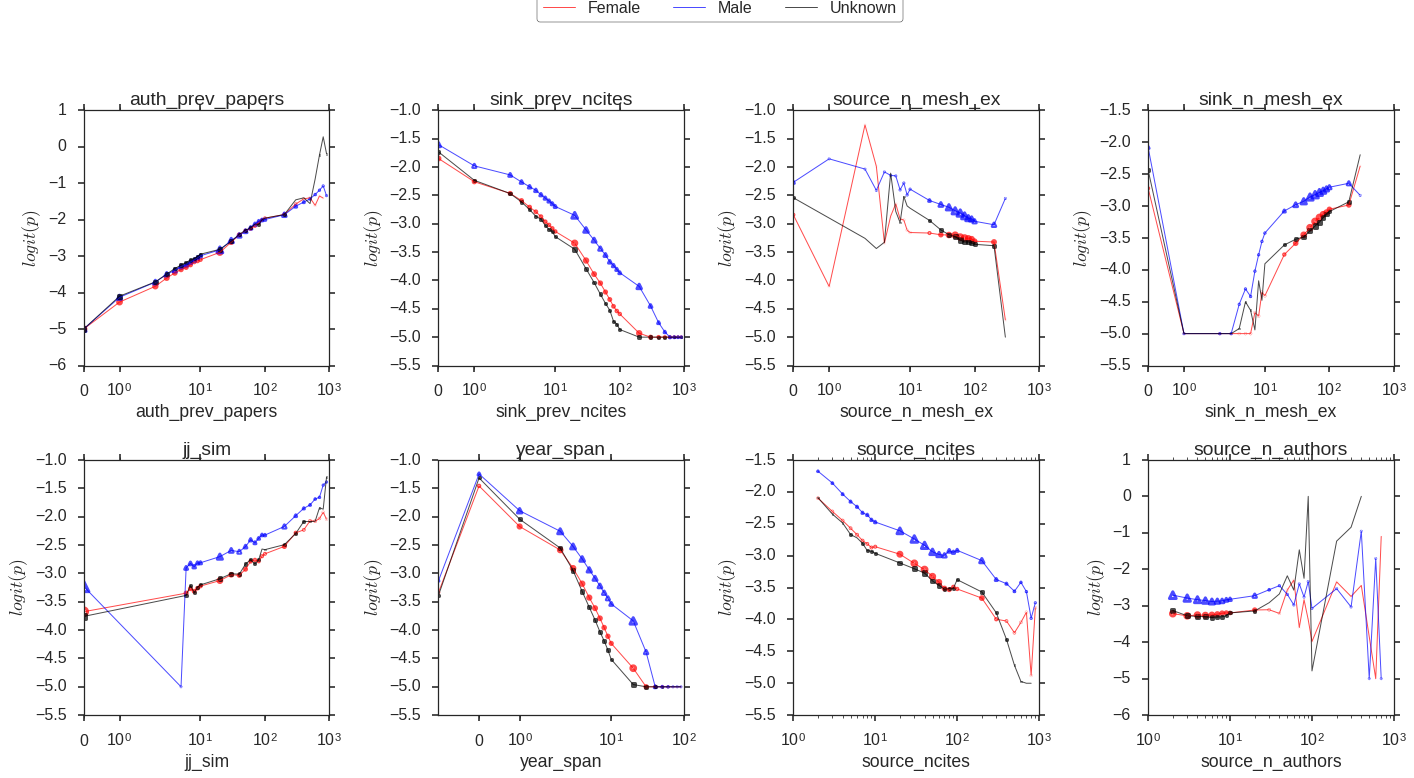

In [95]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('Greys')
plt.clf()
plt.close("all")
fig, ax = plt.subplots(2,4,figsize=(20,10))
ax = ax.flatten()
plot_id = 0
y_feature_col = "is_self_cite"
xcols = ["auth_prev_papers", "sink_prev_ncites", 
         "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim",
         "year_span", "source_ncites", "source_n_authors"]
for k in xcols:
    if k in ["auth_prev_papers", "sink_prev_ncites", "source_n_mesh_ex", "sink_n_mesh_ex", "jj_sim"]:
        bins = np.array([-0.1] + range(10) + range(10,100,10) + range(100,1000,100))
        xscale = "symlog"
        xlims = [0, 1000]
    if k in ["source_ncites", "source_n_authors"]:
        bins = np.array(range(1,10) + range(10,100,10) + range(100,1000,100))
        xscale = "log"
        xlims = [1, 1000]
    if k in ["year_span"]:
        bins = np.array([-10, -1] + range(10) + range(10,100,10))
        xscale = "symlog"
        xlims = [-1, 100]
    print k
    t = get_empirical_logit(df, k, y_feature_col,
    conditioning_var="gender",
    bins=bins,
    testing=False)
    t_logit = logit(t["mean"]).clip(-5,5)
    lgd_items = []
    for j,c in enumerate(conditioning_names):
        scp = ax[plot_id].scatter(t_logit.index, t_logit[c], edgecolor=colors[j], s=t["len"][c] / 1e5, 
                                  facecolor='none', alpha=0.7, linewidth=3, marker=markers[j])
        line, = ax[plot_id].plot(t_logit[t_logit[c].notnull()].index, t_logit[t_logit[c].notnull()][c],
                                 marker="None", linestyle="-", color=colors[j], label=c, lw=1, alpha=0.7)
        lgd_items.append(line)
    ax[plot_id].set_xlabel(k)
    ax[plot_id].set_ylabel("$logit(p)$")
    ax[plot_id].set_title(k)
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    plot_id += 1

#ax.legend(handles=lgd_items, loc="upper center", ncol=3)
lgd = fig.legend(lgd_items, ["Female", "Male", "Unknown"],
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.1), ncol=3,
                 frameon=True, fancybox=True, prop={"size": 16})
fig.tight_layout()


source_T_novelty
source_T_novelty gender is_self_cite
source_V_novelty
source_V_novelty gender is_self_cite
source_PT_novelty
source_PT_novelty gender is_self_cite
source_PV_novelty
source_PV_novelty gender is_self_cite
sink_T_novelty
sink_T_novelty gender is_self_cite
sink_V_novelty
sink_V_novelty gender is_self_cite
sink_PT_novelty
sink_PT_novelty gender is_self_cite
sink_PV_novelty
sink_PV_novelty gender is_self_cite


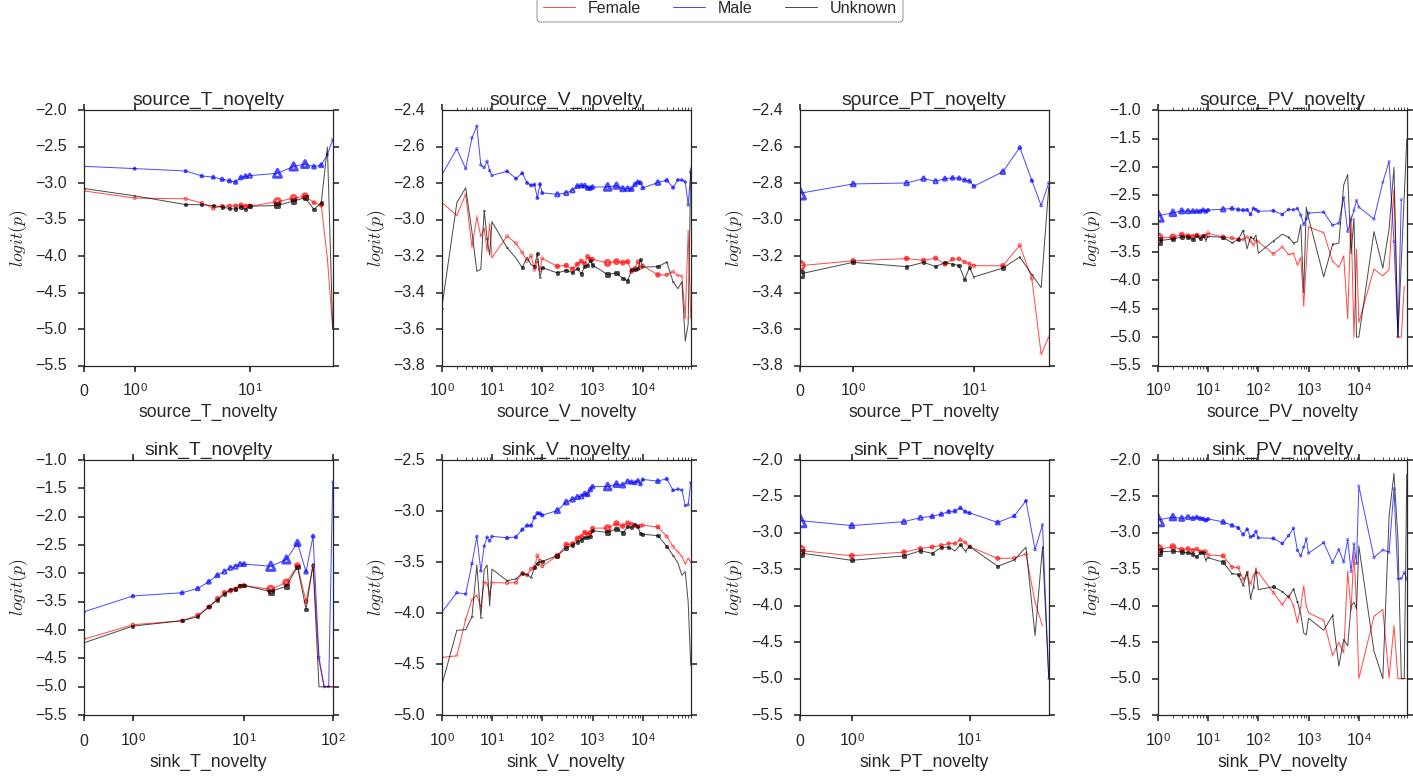

In [96]:
colors = ["r", "b", "k"]
markers = ["o", "^", "s"]
conditioning_names = ["F", "M", "-"]
cm = plt.cm.get_cmap('Greys')
plt.clf()
plt.close("all")
fig, ax = plt.subplots(2,4,figsize=(20,10))
ax = ax.flatten()
plot_id = 0
y_feature_col = "is_self_cite"
xcols = ["source_T_novelty", "source_V_novelty", 
         "source_PT_novelty", "source_PV_novelty",
         "sink_T_novelty", "sink_V_novelty", 
         "sink_PT_novelty", "sink_PV_novelty",]
for k in xcols:
    if k in ["source_T_novelty", "source_PT_novelty", "sink_T_novelty", "sink_PT_novelty"]:
        bins = np.array([-1] + range(0,10) + range(10,100,10) + range(100,1000,100))
        xscale = "symlog"
        #xlims = [0, 1000]
    if k in ["source_V_novelty", "source_PV_novelty", "sink_V_novelty", "sink_PV_novelty"]:
        bins = np.array(range(0,10) + range(10,100,10) + range(100,1000,100)
                       + range(1000,10000,1000) + range(10000,100000, 10000))
        xscale = "log"
        #xlims = [1, 1000]
    print k
    t = get_empirical_logit(df, k, y_feature_col,
    conditioning_var="gender",
    bins=bins,
    testing=False)
    t_logit = logit(t["mean"]).clip(-5,5)
    lgd_items = []
    for j,c in enumerate(conditioning_names):
        scp = ax[plot_id].scatter(t_logit.index, t_logit[c], edgecolor=colors[j], s=t["len"][c] / 1e5, 
                                  facecolor='none', alpha=0.7, linewidth=3, marker=markers[j])
        line, = ax[plot_id].plot(t_logit[t_logit[c].notnull()].index, t_logit[t_logit[c].notnull()][c],
                                 marker="None", linestyle="-", color=colors[j], label=c, lw=1, alpha=0.7)
        lgd_items.append(line)
    xlims = [t_logit[t_logit[c].notnull()].index.min(),
             t_logit[t_logit[c].notnull()].index.max()]
    ax[plot_id].set_xlabel(k)
    ax[plot_id].set_ylabel("$logit(p)$")
    ax[plot_id].set_title(k)
    ax[plot_id].set_xscale(xscale)
    ax[plot_id].set_xlim(xlims)
    plot_id += 1

#ax.legend(handles=lgd_items, loc="upper center", ncol=3)
lgd = fig.legend(lgd_items, ["Female", "Male", "Unknown"],
                 loc = 'upper center',
                 bbox_to_anchor=(0.5,1.1), ncol=3,
                 frameon=True, fancybox=True, prop={"size": 16})
fig.tight_layout()


In [97]:
formula = ("is_self_cite ~ I(auth_prev_papers == 0) + np.log10(auth_prev_papers + 1)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites)*I(source_ncites <= 10)"
           "+ I(source_n_authors == 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + I(jj_sim == 5) + np.log10(jj_sim + 1) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
          )
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
model = Logit(y,X)
res = model.fit()
res.summary2()

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
         Current function value: 0.153446
         Iterations: 35


/content/smishra8/SOFTWARE/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:472: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                     Results: Logit
=========================================================================================================================
Model:                                 Logit                             Pseudo R-squared:                  0.210        
Dependent Variable:                    is_self_cite                      AIC:                               12772438.5167
Date:                                  2016-05-21 23:36                  BIC:                               12773417.7920
No. Observations:                      41618369                          Log-Likelihood:                    -6.3862e+06  
Df Model:                              62                                LL-Null:                           -8.0787e+06  
Df Residuals:                          41618306                          LLR p-value:                       0.0000       
Converged:                             0.0000                            Scale:                             1.0000       
No. Iterations:                        35.0000                                                                           
-------------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.     z     P>|z|    [0.025   0.975] 
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -2.7456   0.0237 -116.0774 0.0000   -2.7919  -2.6992
I(auth_prev_papers == 0)[T.True]                                     -1.5288   0.0080 -191.1856 0.0000   -1.5445  -1.5132
C(gender, levels=GENDERS)[T.F]                                       -0.0208   0.0033   -6.2603 0.0000   -0.0274  -0.0143
C(gender, levels=GENDERS)[T.M]                                       -0.0376   0.0031  -12.2477 0.0000   -0.0436  -0.0316
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.0769   0.0026  -29.1121 0.0000   -0.0821  -0.0717
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0067   0.0032   -2.0794 0.0376   -0.0131  -0.0004
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.2505   0.0063   39.6616 0.0000    0.2381   0.2628
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 0.0259   0.0042    6.1935 0.0000    0.0177   0.0341
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.0410   0.0053   -7.7821 0.0000   -0.0513  -0.0307
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                  -0.1040   0.0065  -15.9286 0.0000   -0.1168  -0.0912
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.0090   0.0042   -2.1302 0.0332   -0.0173  -0.0007
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.4433   0.0099  -44.6869 0.0000   -0.4627  -0.4238
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               0.0894   0.0052   17.1364 0.0000    0.0792   0.0997
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                  -0.1264   0.0063  -20.0059 0.0000   -0.1388  -0.1140
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             0.0543   0.0071    7.6334 0.0000    0.0404   0.0683
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  0.0885   0.0067   13.2291 0.0000    0.0754   0.1016
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.0527   0.0104   -5.0471 0.0000   -0.0732  -0.0323
C(source_country, levels=TOP_15_COUNTRIES)[T.SWITZERLAND]            -0.0342   0.0069   -4.9304 0.0000   -0.0478  -0.0206
I(source_ncites <= 10)[T.True]                                       -0.0460   0.0106   -4.3324 0.0000   -0.0669  -0.0252
I(source_n_authors == 20)[T.True]                                    -0.0377   0.0267   -1.4138 0.157

In [104]:
(np.exp(res.params[res.params.index.str.startswith("mf.MC")]) - 1).sort_values()

mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[12]   -0.029670
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[0]    -0.013119
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[5]     0.067386
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[6]     0.067486
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[9]     0.080578
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[3]     0.080657
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[13]    0.082838
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[2]     0.135603
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[11]    0.138536
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[4]     0.190107
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[1]     0.218295
mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)[7]     0.219412
mf.MC(eth1, eth2, weights=et

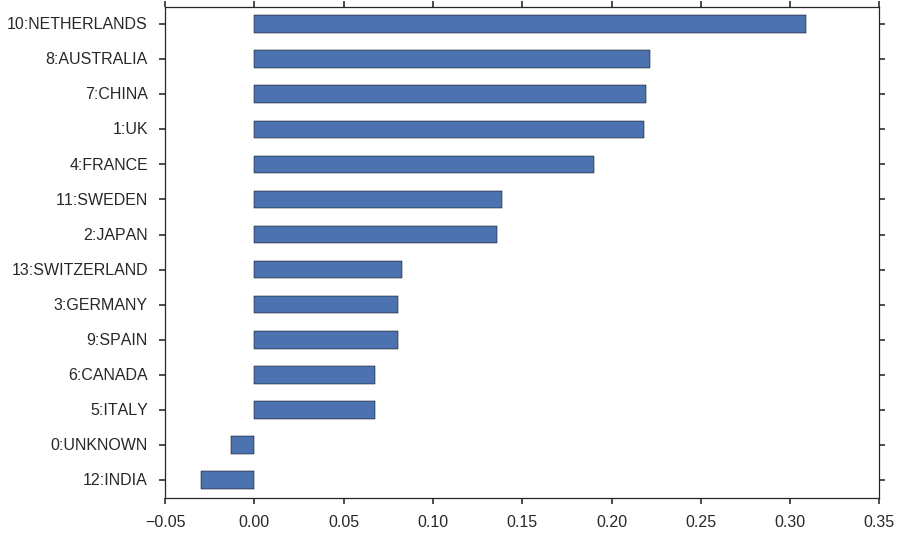

In [98]:
t = np.exp(res.params[res.params.index.str.startswith("mf.MC")]) - 1
t.index = ["%s:%s" % (i,k) for i,k in enumerate(TOP_15_COUNTRIES[1:])]
t.sort_values().plot(kind="barh")
#plt.gca().set_yticklabels(TOP_15_COUNTRIES[1:])

In [100]:
np.exp(res.params[res.params.index.str.startswith("C(source_country")]).sort_values()

C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]          0.641921
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]          0.881264
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]          0.901235
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]        0.926004
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]          0.948632
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]         0.959836
C(source_country, levels=TOP_15_COUNTRIES)[T.SWITZERLAND]    0.966397
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]         0.991017
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]             0.993285
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]        1.026220
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]    1.055842
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]         1.092494
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]      1.093543
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]          1.284623
dtype: float64

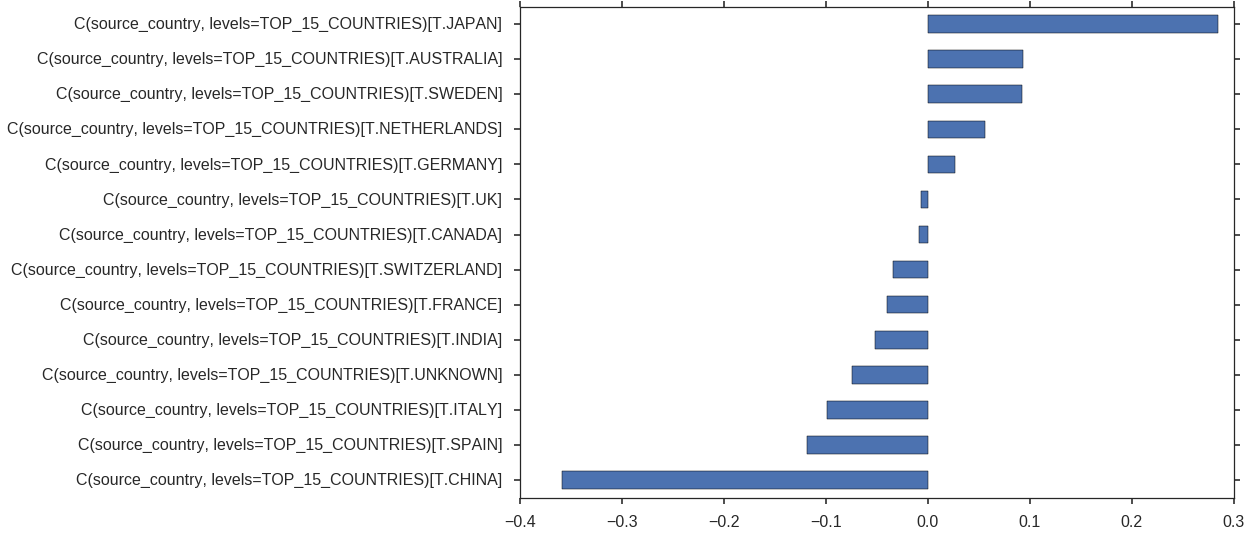

In [101]:
(np.exp(res.params[res.params.index.str.startswith("C(source_country")]) - 1).sort_values().plot(kind="barh")

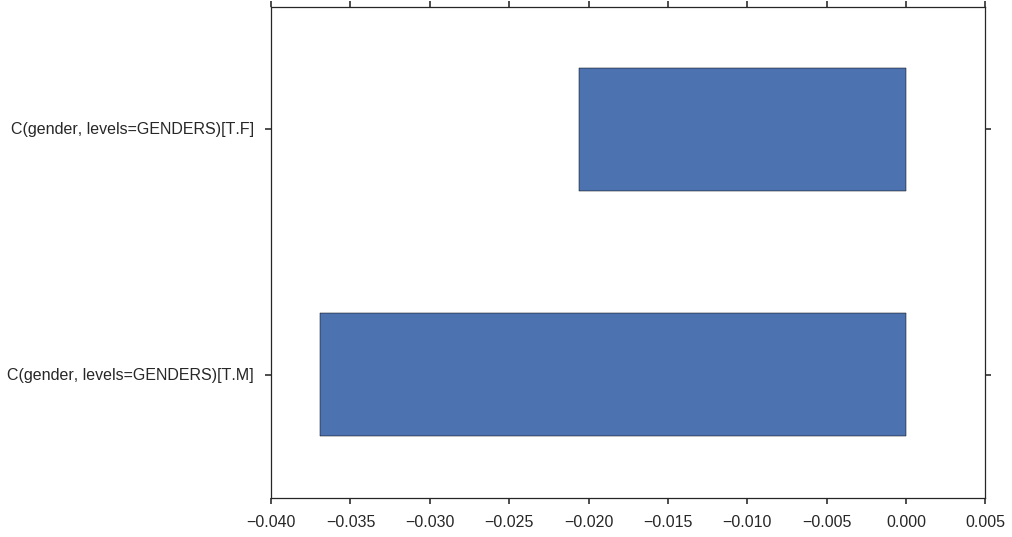

In [102]:
(np.exp(res.params[res.params.index.str.startswith("C(gender")]) - 1).sort_values().plot(kind="barh")

In [105]:
formula = ("is_self_cite ~ I(auth_prev_papers == 0) + np.log10(auth_prev_papers + 1)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites) + I(source_ncites <= 10)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) +1) + np.isnan(source_V_novelty) + np.log10(np.nan_to_num(source_PV_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
           "+ np.isnan(sink_V_novelty) + np.log10(np.nan_to_num(sink_PV_novelty) + 1)"
          )
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
model = Logit(y,X)
res = model.fit()
res.summary2()

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Optimization terminated successfully.
         Current function value: 0.153218
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                      Results: Logit
==========================================================================================================================================================
Model:                                            Logit                                        Pseudo R-squared:                             0.211        
Dependent Variable:                               is_self_cite                                 AIC:                                          12753520.5418
Date:                                             2016-05-22 02:21                             BIC:                                          12754546.4492
No. Observations:                                 41618369                                     Log-Likelihood:                               -6.3767e+06  
Df Model:                                         65                                           LL-Null:                                      -8.0787e+06  
Df Residuals:                                     41618303                                     LLR p-value:                                  0.0000       
Converged:                                        1.0000                                       Scale:                                        1.0000       
No. Iterations:                                   10.0000                                                                                                 
----------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                      Coef.        Std.Err.          z     P>|z|         [0.025               0.975]      
----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -1.4948              0.0133 -112.0132 0.0000              -1.5209             -1.4686
I(auth_prev_papers == 0)[T.True]                                     -1.5214              0.0080 -190.2347 0.0000              -1.5371             -1.5057
C(gender, levels=GENDERS)[T.F]                                       -0.0198              0.0033   -5.9246 0.0000              -0.0263             -0.0132
C(gender, levels=GENDERS)[T.M]                                       -0.0358              0.0030  -11.7321 0.0000              -0.0417             -0.0298
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.0763              0.0026  -29.0390 0.0000              -0.0814             -0.0711
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0068              0.0032   -2.0988 0.0358              -0.0131             -0.0004
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.2470              0.0063   39.1730 0.0000               0.2346              0.2593
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 0.0227              0.0042    5.4300 0.0000               0.0145              0.0309
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.0432              0.0053   -8.2169 0.0000              -0.0536             -0.0329
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                  -0.1026              0.0065  -15.7190 0.0000              -0.1154             -0.0898
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.0064              0.0042   -1.5149 0.1298              -0.0147              0.0019
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.4461              0.0099  -44.8866 0.0000              -0.4656             -0.4266
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               0.0877              0.0052   16.8087 0.0000               0.0774            

In [106]:
formula = ("is_self_cite ~ I(auth_prev_papers == 0) + np.log10(auth_prev_papers + 1)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites) + I(source_ncites <= 10)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) +1) + np.isnan(source_PV_novelty) + np.log10(np.nan_to_num(source_PV_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
           "+ np.isnan(sink_PV_novelty) + np.log10(np.nan_to_num(sink_PV_novelty) + 1)"
          )
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
model = Logit(y,X)
res = model.fit()
res.summary2()

Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Using class based MultiVal
using complimentary weights for 2 columns. w and 1-w
Optimization terminated successfully.
         Current function value: 0.153216
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                    Results: Logit
======================================================================================================================
Model:                                Logit                            Pseudo R-squared:                 0.211        
Dependent Variable:                   is_self_cite                     AIC:                              12753317.4980
Date:                                 2016-05-22 10:13                 BIC:                              12754374.4935
No. Observations:                     41618369                         Log-Likelihood:                   -6.3766e+06  
Df Model:                             67                               LL-Null:                          -8.0787e+06  
Df Residuals:                         41618301                         LLR p-value:                      0.0000       
Converged:                            1.0000                           Scale:                            1.0000       
No. Iterations:                       10.0000                                                                         
----------------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                                            -1.4655   0.0273  -53.6604 0.0000 -1.5190 -1.4120
I(auth_prev_papers == 0)[T.True]                                     -1.5214   0.0080 -190.2738 0.0000 -1.5371 -1.5057
C(gender, levels=GENDERS)[T.F]                                       -0.0198   0.0033   -5.9293 0.0000 -0.0263 -0.0132
C(gender, levels=GENDERS)[T.M]                                       -0.0358   0.0031  -11.6422 0.0000 -0.0418 -0.0298
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                -0.0763   0.0026  -28.8693 0.0000 -0.0815 -0.0711
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                     -0.0068   0.0032   -2.0979 0.0359 -0.0132 -0.0004
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                   0.2469   0.0063   39.1541 0.0000  0.2346  0.2593
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 0.0227   0.0042    5.4384 0.0000  0.0145  0.0309
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                 -0.0433   0.0053   -8.2236 0.0000 -0.0536 -0.0330
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                  -0.1026   0.0065  -15.7154 0.0000 -0.1154 -0.0898
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                 -0.0065   0.0042   -1.5272 0.1267 -0.0148  0.0018
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                  -0.4461   0.0099  -44.9287 0.0000 -0.4656 -0.4267
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               0.0877   0.0052   16.7905 0.0000  0.0775  0.0979
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                  -0.1228   0.0063  -19.4285 0.0000 -0.1352 -0.1104
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             0.0646   0.0071    9.0795 0.0000  0.0507  0.0786
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                  0.0930   0.0067   13.9064 0.0000  0.0799  0.1061
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                  -0.0597   0.0105   -5.7099 0.0000 -0.0802 -0.0392
C(source_country, levels=TOP_15_COUNTRIES)[T.SWITZERLAND]            -0.0363   0.0069   -5.2361 0.0000 -0.0499 -0.0227
I(source_ncites <= 10)[T.True]                                       -0.0914   0.0037  -24.8316 0.0000 -0.0986 -0.0842
I(source_n_authors > 20)[T.True]                                     -0.1164   0.0138   -8.4238 0.0000 -0.1435 -0.0893
I(source_n_mesh_ex == 0)[T.True]                                     -0.5531

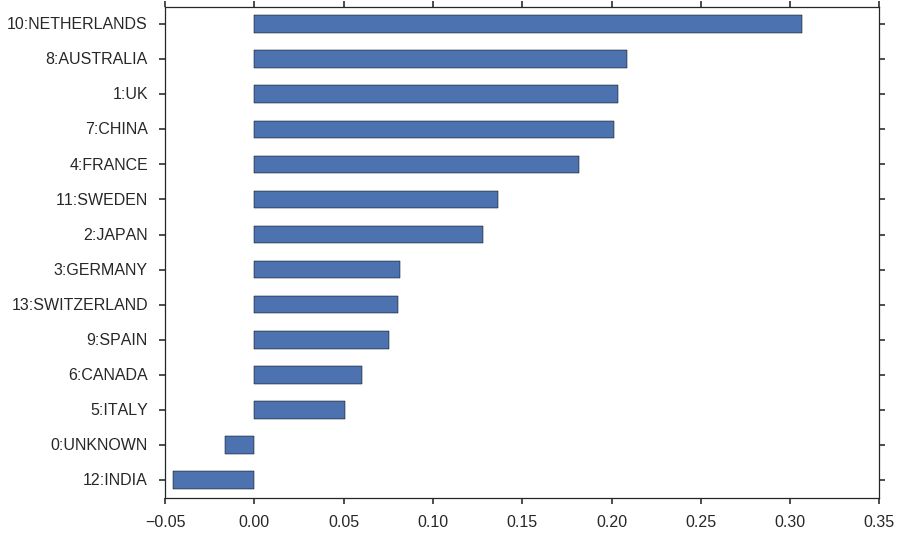

In [107]:
t = np.exp(res.params[res.params.index.str.startswith("mf.MC")]) - 1
t.index = ["%s:%s" % (i,k) for i,k in enumerate(TOP_15_COUNTRIES[1:])]
t.sort_values().plot(kind="barh")
#plt.gca().set_yticklabels(TOP_15_COUNTRIES[1:])

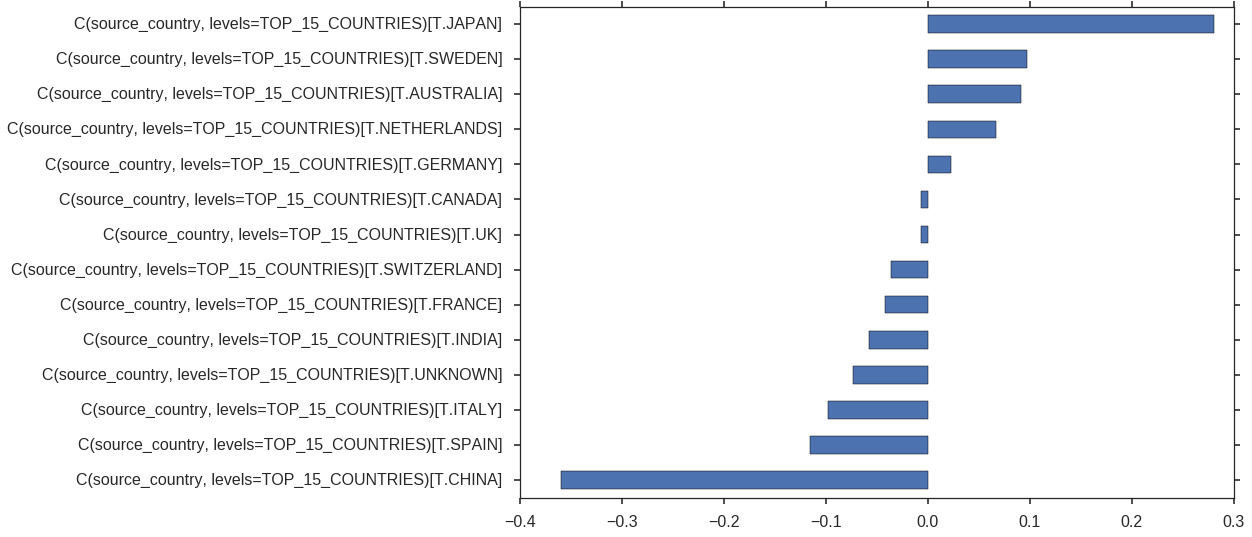

In [108]:
(np.exp(res.params[res.params.index.str.startswith("C(source_country")]) - 1).sort_values().plot(kind="barh")

In [113]:
res.summary2().tables[1].index

Index([u'Intercept', u'I(auth_prev_papers == 0)[T.True]',
       u'C(gender, levels=GENDERS)[T.F]', u'C(gender, levels=GENDERS)[T.M]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.UK]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]',
       u'C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]',
       u'C(source_country, level

In [115]:
y.head()

,is_self_cite
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


In [116]:
with pd.HDFStore("out/Model.v2.h5", mode="w",) as store:
    store["X"] = X
    print "Finished X"
    store["y"] = y
    print "Finished y"

Finished X
Finished y


In [117]:
! ls -ltrh out/Model.v2.h5

-rw-rw-r-- 1 smishra8 authority 23G May 22 18:04 out/Model.v2.h5


## Model with Gender and affiliation interaction

In [12]:
formula = ("is_self_cite ~ mf.score_k(auth_prev_papers, 0) + np.log10(auth_prev_papers + 1)"
           " + np.log10(source_ncites) + np.log10(source_n_authors) + np.log10(source_n_mesh + 1)"
          " + C(gender, levels=GENDERS)*C(source_country, levels=TOP_15_COUNTRIES)"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com")
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
model = Logit(y,X)
res = model.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.174912
         Iterations 10


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                              Results: Logit
==========================================================================================================================================
Model:                                      Logit                                   Pseudo R-squared:                        0.099        
Dependent Variable:                         is_self_cite                            AIC:                                     14559251.0906
Date:                                       2016-05-18 11:43                        BIC:                                     14560106.0135
No. Observations:                           41618369                                Log-Likelihood:                          -7.2796e+06  
Df Model:                                   54                                      LL-Null:                                 -8.0787e+06  
Df Residuals:                               41618314                                LLR p-value:                             0.0000       
Converged:                                  1.0000                                  Scale:                                   1.0000       
No. Iterations:                             10.0000                                                                                       
------------------------------------------------------------------------------------------------------------------------------------------
                                                                                          Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                -2.7631   0.0138 -200.7650 0.0000 -2.7900 -2.7361
mf.score_k(auth_prev_papers, 0)[T.True]                                                  -1.5402   0.0079 -193.8732 0.0000 -1.5557 -1.5246
C(gender, levels=GENDERS)[T.F]                                                           -0.1522   0.0043  -35.7860 0.0000 -0.1605 -0.1438
C(gender, levels=GENDERS)[T.M]                                                           -0.0837   0.0037  -22.3287 0.0000 -0.0911 -0.0764
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                                    -0.3356   0.0061  -54.8053 0.0000 -0.3477 -0.3236
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                                         -0.1275   0.0110  -11.5926 0.0000 -0.1491 -0.1059
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                                      -0.0079   0.0077   -1.0235 0.3061 -0.0230  0.0072
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                                     0.0148   0.0164    0.9036 0.3662 -0.0173  0.0470
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                                     -0.2286   0.0193  -11.8606 0.0000 -0.2664 -0.1909
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                                      -0.3294   0.0299  -11.0335 0.0000 -0.3879 -0.2708
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                                     -0.0485   0.0128   -3.7907 0.0002 -0.0735 -0.0234
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                                      -0.4333   0.0115  -37.7656 0.0000 -0.4558 -0.4108
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]                                   0.0626   0.0167    3.7523 0.0002  0.0299  0.0954
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                                      -0.0740   0.0302   -2.4519 0.0142 -0.1332 -0.0149
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]                                 0.0338   0.0176    1.9234 0.0544 -0.0006  0.0683
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                                      0.1178   0.0224    5.2662 0.000

## Multiple model training using joblib

In [7]:
from joblib import Parallel, delayed

In [8]:
formula = ("is_self_cite ~ journal_same + mesh_sim"
           " + lang_sim + pubtype_sim"
          " + np.log10(auth_prev_papers + 1) + np.log10(sink_prev_ncites + 1)"
           " + np.log10(source_ncites) + np.log10(source_n_authors) + np.log10(source_n_mesh + 1)"
          " + C(gender, levels=GENDERS)")
y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")

In [9]:
def model_fit(y,X,feature_key="Gender"):
    model = Logit(y,X)
    res = model.fit()
    return feature_key, (res.llf, res.summary2())

In [10]:
X.columns

Index([u'Intercept', u'journal_same[T.True]',
       u'C(gender, levels=GENDERS)[T.F]', u'C(gender, levels=GENDERS)[T.M]',
       u'mesh_sim', u'lang_sim', u'pubtype_sim',
       u'np.log10(auth_prev_papers + 1)', u'np.log10(sink_prev_ncites + 1)',
       u'np.log10(source_ncites)', u'np.log10(source_n_authors)',
       u'np.log10(source_n_mesh + 1)'],
      dtype='object')

In [14]:
y.head()

,is_self_cite[False],is_self_cite[True]
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [11]:
feature_dict = {
    "JournalSim": [u'journal_same[T.True]'],
    "Gender": [u'C(gender, levels=GENDERS)[T.F]', u'C(gender, levels=GENDERS)[T.M]'],
    "MeSHSim": [u'mesh_sim'],
    "LanguageSim": [u'lang_sim'],
    "PubTypeSim": [u'pubtype_sim'],
    "AuthorAge": [u'np.log10(auth_prev_papers + 1)'],
    "PriorCites": [u'np.log10(sink_prev_ncites + 1)'],
    "SourceRefs": [u'np.log10(source_ncites)'],
    "SourceAuthors": [u'np.log10(source_n_authors)'],
    "SourceMeSH": [u'np.log10(source_n_mesh + 1)']
}

In [12]:
del df

In [15]:
results = Parallel(n_jobs=10, verbose=5,
                   temp_folder="./tmp", max_nbytes="50G")(delayed(model_fit)(y["is_self_cite[True]"], X[["Intercept"] + v], k)
                                         for k,v in feature_dict.iteritems())

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.194005
         Current function value: 0.189792
         Current function value: 0.192768
         Current function value: 0.193800
         Current function value: 0.191226
         Current function value: 0.193090
         Current function value: 0.194100
         Current function value: 0.180043
         Current function value: 0.187935
         Current function value: 0.178207
         Iterations 8
         Iterations 7
         Iterations 7
         Iterations 7
         Iterations 7
         Iterations 7
         Iterations 7
         Iterations 8
         Iterations 7
  

[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  7.5min finished


In [16]:
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

PriorCites -7416670.13571
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:    0.082        
Dependent Variable:      is_self_cite[True]    AIC:                 14833344.2714
Date:                    2016-05-14 03:34      BIC:                 14833375.3595
No. Observations:        41618369              Log-Likelihood:      -7.4167e+06  
Df Model:                1                     LL-Null:             -8.0787e+06  
Df Residuals:            41618367              LLR p-value:         0.0000       
Converged:               1.0000                Scale:               1.0000       
No. Iterations:          8.0000                                                  
---------------------------------------------------------------------------------
                                Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------
Intercept               

In [17]:
TOP_FEATURE = sorted(results, key=lambda x: x[1][0], reverse=True)[0][0]
print TOP_FEATURE

PriorCites


In [18]:
results_2 = Parallel(n_jobs=10, verbose=5,
                   temp_folder="./tmp", max_nbytes="1M")(delayed(model_fit)(y["is_self_cite[True]"],
                                                                            X[["Intercept"] + feature_dict[TOP_FEATURE] + v], k)
                                         for k,v in feature_dict.iteritems() if k != TOP_FEATURE)

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.177991
         Current function value: 0.174848
         Current function value: 0.177795
         Current function value: 0.178200
         Current function value: 0.178204
         Current function value: 0.174245
         Current function value: 0.176717
         Current function value: 0.163543
         Current function value: 0.177281
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8


[Parallel(n_jobs=10)]: Done   9 out of   9 | elapsed:  6.5min finished


In [19]:
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

AuthorAge -6806384.13926
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:    0.157        
Dependent Variable:      is_self_cite[True]    AIC:                 13612774.2785
Date:                    2016-05-14 03:48      BIC:                 13612820.9107
No. Observations:        41618369              Log-Likelihood:      -6.8064e+06  
Df Model:                2                     LL-Null:             -8.0787e+06  
Df Residuals:            41618366              LLR p-value:         0.0000       
Converged:               1.0000                Scale:               1.0000       
No. Iterations:          8.0000                                                  
---------------------------------------------------------------------------------
                                Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------
Intercept                

In [21]:
print "Stage 1"
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "Stage 2"
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 


Stage 1
PriorCites: -7416670.1357 AuthorAge: -7493079.6403 MeSHSim: -7821557.7682 PubTypeSim: -7898829.7948 JournalSim: -7958515.1835 SourceRefs: -8022698.1878 Gender: -8036083.2022 SourceMeSH: -8065623.0769 LanguageSim: -8074155.3317 SourceAuthors: -8078136.1043 Stage 2
AuthorAge: -6806384.1393 MeSHSim: -7251795.5991 PubTypeSim: -7276873.4618 JournalSim: -7354671.5450 Gender: -7378156.2750 SourceRefs: -7399534.5622 LanguageSim: -7407680.2752 SourceAuthors: -7416404.7554 SourceMeSH: -7416558.7581


In [22]:
TOP_FEATURE_2 = sorted(results_2, key=lambda x: x[1][0], reverse=True)[0][0]
print TOP_FEATURE_2

AuthorAge


In [23]:
results_3 = Parallel(n_jobs=10,
                     verbose=5,
                   temp_folder="./tmp",
                     max_nbytes="1M")(
    delayed(model_fit)(
        y["is_self_cite[True]"], 
        X[["Intercept"] + feature_dict[TOP_FEATURE] + feature_dict[TOP_FEATURE_2] + v],
        k)
    for k,v in feature_dict.iteritems() if k not in [TOP_FEATURE, TOP_FEATURE_2])

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.161610
         Current function value: 0.158049
         Current function value: 0.163199
         Current function value: 0.163535
         Current function value: 0.161804
         Current function value: 0.163542
         Current function value: 0.163527
         Current function value: 0.159914
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8


[Parallel(n_jobs=10)]: Done   8 out of   8 | elapsed:  7.1min finished


In [25]:
print "Stage 1"
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 2"
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 3"
for k,(ll,summary) in sorted(results_3, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
    


Stage 1
PriorCites: -7416670.1357 AuthorAge: -7493079.6403 MeSHSim: -7821557.7682 PubTypeSim: -7898829.7948 JournalSim: -7958515.1835 SourceRefs: -8022698.1878 Gender: -8036083.2022 SourceMeSH: -8065623.0769 LanguageSim: -8074155.3317 SourceAuthors: -8078136.1043 
Stage 2
AuthorAge: -6806384.1393 MeSHSim: -7251795.5991 PubTypeSim: -7276873.4618 JournalSim: -7354671.5450 Gender: -7378156.2750 SourceRefs: -7399534.5622 LanguageSim: -7407680.2752 SourceAuthors: -7416404.7554 SourceMeSH: -7416558.7581 
Stage 3
PubTypeSim: -6577728.4142 MeSHSim: -6655368.5734 JournalSim: -6725930.3249 SourceRefs: -6734001.6839 LanguageSim: -6792061.2274 SourceAuthors: -6805737.4226 Gender: -6806045.2505 SourceMeSH: -6806336.8768


In [26]:
for k,(ll,summary) in sorted(results_3, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

PubTypeSim -6577728.41416
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:    0.186        
Dependent Variable:      is_self_cite[True]    AIC:                 13155464.8283
Date:                    2016-05-14 04:00      BIC:                 13155527.0045
No. Observations:        41618369              Log-Likelihood:      -6.5777e+06  
Df Model:                3                     LL-Null:             -8.0787e+06  
Df Residuals:            41618365              LLR p-value:         0.0000       
Converged:               1.0000                Scale:               1.0000       
No. Iterations:          8.0000                                                  
---------------------------------------------------------------------------------
                                Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------
Intercept               

In [27]:
TOP_FEATURE_3 = sorted(results_3, key=lambda x: x[1][0], reverse=True)[0][0]
print TOP_FEATURE_3

PubTypeSim


In [ ]:
results_4 = Parallel(n_jobs=len(feature_dict) - 3,
                     verbose=5,
                   temp_folder="./tmp",
                     max_nbytes="1M")(
    delayed(model_fit)(
        y["is_self_cite[True]"], 
        X[["Intercept"] 
          + feature_dict[TOP_FEATURE] 
          + feature_dict[TOP_FEATURE_2] 
          + feature_dict[TOP_FEATURE_3]
          + v],
        k)
    for k,v in feature_dict.iteritems() if k not in [TOP_FEATURE, TOP_FEATURE_2, TOP_FEATURE_3])

In [34]:
print "Stage 1"
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 2"
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 3"
for k,(ll,summary) in sorted(results_3, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 4"
for k,(ll,summary) in sorted(results_4, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),


Stage 1
PriorCites: -7416670.1357 AuthorAge: -7493079.6403 MeSHSim: -7821557.7682 PubTypeSim: -7898829.7948 JournalSim: -7958515.1835 SourceRefs: -8022698.1878 Gender: -8036083.2022 SourceMeSH: -8065623.0769 LanguageSim: -8074155.3317 SourceAuthors: -8078136.1043 
Stage 2
AuthorAge: -6806384.1393 MeSHSim: -7251795.5991 PubTypeSim: -7276873.4618 JournalSim: -7354671.5450 Gender: -7378156.2750 SourceRefs: -7399534.5622 LanguageSim: -7407680.2752 SourceAuthors: -7416404.7554 SourceMeSH: -7416558.7581 
Stage 3
PubTypeSim: -6577728.4142 MeSHSim: -6655368.5734 JournalSim: -6725930.3249 SourceRefs: -6734001.6839 LanguageSim: -6792061.2274 SourceAuthors: -6805737.4226 Gender: -6806045.2505 SourceMeSH: -6806336.8768 
Stage 4
MeSHSim: -6460158.4095 JournalSim: -6516272.5379 SourceRefs: -6524316.4621 LanguageSim: -6572052.6972 SourceAuthors: -6577539.1334 Gender: -6577634.2193 SourceMeSH: -6577708.4761


In [36]:
for k,(ll,summary) in sorted(results_4, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

MeSHSim -6460158.40945
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:    0.200        
Dependent Variable:      is_self_cite[True]    AIC:                 12920326.8189
Date:                    2016-05-14 04:18      BIC:                 12920404.5392
No. Observations:        41618369              Log-Likelihood:      -6.4602e+06  
Df Model:                4                     LL-Null:             -8.0787e+06  
Df Residuals:            41618364              LLR p-value:         0.0000       
Converged:               1.0000                Scale:               1.0000       
No. Iterations:          8.0000                                                  
---------------------------------------------------------------------------------
                                Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------
Intercept                  

In [37]:
TOP_FEATURE_4 = sorted(results_4, key=lambda x: x[1][0], reverse=True)[0][0]
print TOP_FEATURE_4

MeSHSim


In [38]:
results_5 = Parallel(n_jobs=len(feature_dict) - 4,
                     verbose=5,
                   temp_folder="./tmp",
                     max_nbytes="1M")(
    delayed(model_fit)(
        y["is_self_cite[True]"], 
        X[["Intercept"] 
          + feature_dict[TOP_FEATURE] 
          + feature_dict[TOP_FEATURE_2] 
          + feature_dict[TOP_FEATURE_3]
          + feature_dict[TOP_FEATURE_4]
          + v],
        k)
    for k,v in feature_dict.iteritems() if k not in [TOP_FEATURE,
                                                     TOP_FEATURE_2,
                                                     TOP_FEATURE_3,
                                                     TOP_FEATURE_4])

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.155048
         Current function value: 0.155163
         Current function value: 0.155220
         Current function value: 0.154185
         Current function value: 0.155184
         Current function value: 0.154482
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8


[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:  6.3min finished


In [39]:
print "Stage 1"
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 2"
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 3"
for k,(ll,summary) in sorted(results_3, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 4"
for k,(ll,summary) in sorted(results_4, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 5"
for k,(ll,summary) in sorted(results_5, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),


Stage 1
PriorCites: -7416670.1357 AuthorAge: -7493079.6403 MeSHSim: -7821557.7682 PubTypeSim: -7898829.7948 JournalSim: -7958515.1835 SourceRefs: -8022698.1878 Gender: -8036083.2022 SourceMeSH: -8065623.0769 LanguageSim: -8074155.3317 SourceAuthors: -8078136.1043 
Stage 2
AuthorAge: -6806384.1393 MeSHSim: -7251795.5991 PubTypeSim: -7276873.4618 JournalSim: -7354671.5450 Gender: -7378156.2750 SourceRefs: -7399534.5622 LanguageSim: -7407680.2752 SourceAuthors: -7416404.7554 SourceMeSH: -7416558.7581 
Stage 3
PubTypeSim: -6577728.4142 MeSHSim: -6655368.5734 JournalSim: -6725930.3249 SourceRefs: -6734001.6839 LanguageSim: -6792061.2274 SourceAuthors: -6805737.4226 Gender: -6806045.2505 SourceMeSH: -6806336.8768 
Stage 4
MeSHSim: -6460158.4095 JournalSim: -6516272.5379 SourceRefs: -6524316.4621 LanguageSim: -6572052.6972 SourceAuthors: -6577539.1334 Gender: -6577634.2193 SourceMeSH: -6577708.4761 
Stage 5
JournalSim: -6416941.3021 SourceRefs: -6429303.0161 LanguageSim: -6452861.2156 SourceM

In [41]:
for k,(ll,summary) in sorted(results_5, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

JournalSim -6416941.30209
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:    0.206        
Dependent Variable:      is_self_cite[True]    AIC:                 12833894.6042
Date:                    2016-05-14 13:36      BIC:                 12833987.8685
No. Observations:        41618369              Log-Likelihood:      -6.4169e+06  
Df Model:                5                     LL-Null:             -8.0787e+06  
Df Residuals:            41618363              LLR p-value:         0.0000       
Converged:               1.0000                Scale:               1.0000       
No. Iterations:          8.0000                                                  
---------------------------------------------------------------------------------
                                Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------
Intercept               

In [42]:
TOP_FEATURE_5 = sorted(results_5, key=lambda x: x[1][0], reverse=True)[0][0]
print TOP_FEATURE_5

JournalSim


In [43]:
results_6 = Parallel(n_jobs=len(feature_dict) - 5,
                     verbose=5,
                   temp_folder="./tmp",
                     max_nbytes="1M")(
    delayed(model_fit)(
        y["is_self_cite[True]"], 
        X[["Intercept"] 
          + feature_dict[TOP_FEATURE] 
          + feature_dict[TOP_FEATURE_2] 
          + feature_dict[TOP_FEATURE_3]
          + feature_dict[TOP_FEATURE_4]
          + feature_dict[TOP_FEATURE_5]
          + v],
        k)
    for k,v in feature_dict.iteritems() if k not in [TOP_FEATURE,
                                                     TOP_FEATURE_2,
                                                     TOP_FEATURE_3,
                                                     TOP_FEATURE_4,
                                                     TOP_FEATURE_5
                                                    ])

Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.154049
         Current function value: 0.153610
         Current function value: 0.154140
         Current function value: 0.154141
         Current function value: 0.154182
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  8.9min finished


In [44]:
print "Stage 1"
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 2"
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 3"
for k,(ll,summary) in sorted(results_3, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 4"
for k,(ll,summary) in sorted(results_4, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 5"
for k,(ll,summary) in sorted(results_5, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 6"
for k,(ll,summary) in sorted(results_6, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),


Stage 1
PriorCites: -7416670.1357 AuthorAge: -7493079.6403 MeSHSim: -7821557.7682 PubTypeSim: -7898829.7948 JournalSim: -7958515.1835 SourceRefs: -8022698.1878 Gender: -8036083.2022 SourceMeSH: -8065623.0769 LanguageSim: -8074155.3317 SourceAuthors: -8078136.1043 
Stage 2
AuthorAge: -6806384.1393 MeSHSim: -7251795.5991 PubTypeSim: -7276873.4618 JournalSim: -7354671.5450 Gender: -7378156.2750 SourceRefs: -7399534.5622 LanguageSim: -7407680.2752 SourceAuthors: -7416404.7554 SourceMeSH: -7416558.7581 
Stage 3
PubTypeSim: -6577728.4142 MeSHSim: -6655368.5734 JournalSim: -6725930.3249 SourceRefs: -6734001.6839 LanguageSim: -6792061.2274 SourceAuthors: -6805737.4226 Gender: -6806045.2505 SourceMeSH: -6806336.8768 
Stage 4
MeSHSim: -6460158.4095 JournalSim: -6516272.5379 SourceRefs: -6524316.4621 LanguageSim: -6572052.6972 SourceAuthors: -6577539.1334 Gender: -6577634.2193 SourceMeSH: -6577708.4761 
Stage 5
JournalSim: -6416941.3021 SourceRefs: -6429303.0161 LanguageSim: -6452861.2156 SourceM

In [45]:
for k,(ll,summary) in sorted(results_6, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

SourceRefs -6393001.93758
                                 Results: Logit
Model:                  Logit                 Pseudo R-squared:    0.209        
Dependent Variable:     is_self_cite[True]    AIC:                 12786017.8752
Date:                   2016-05-14 13:46      BIC:                 12786126.6835
No. Observations:       41618369              Log-Likelihood:      -6.3930e+06  
Df Model:               6                     LL-Null:             -8.0787e+06  
Df Residuals:           41618362              LLR p-value:         0.0000       
Converged:              1.0000                Scale:               1.0000       
No. Iterations:         8.0000                                                  
--------------------------------------------------------------------------------
                                Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                      -4.1

In [46]:
TOP_FEATURE_6 = sorted(results_6, key=lambda x: x[1][0], reverse=True)[0][0]
print TOP_FEATURE_6

SourceRefs


In [47]:
results_7 = Parallel(n_jobs=len(feature_dict) - 6,
                     verbose=5,
                   temp_folder="./tmp",
                     max_nbytes="1M")(
    delayed(model_fit)(
        y["is_self_cite[True]"], 
        X[["Intercept"] 
          + feature_dict[TOP_FEATURE] 
          + feature_dict[TOP_FEATURE_2] 
          + feature_dict[TOP_FEATURE_3]
          + feature_dict[TOP_FEATURE_4]
          + feature_dict[TOP_FEATURE_5]
          + feature_dict[TOP_FEATURE_6]
          + v],
        k)
    for k,v in feature_dict.iteritems() if k not in [TOP_FEATURE,
                                                     TOP_FEATURE_2,
                                                     TOP_FEATURE_3,
                                                     TOP_FEATURE_4,
                                                     TOP_FEATURE_5,
                                                     TOP_FEATURE_6
                                                    ])

[Parallel(n_jobs=4)]: Done   5 out of   4 | elapsed:  7.9min remaining:  -94.6s
[Parallel(n_jobs=4)]: Done   5 out of   4 | elapsed:  7.9min remaining:  -94.9s
[Parallel(n_jobs=4)]: Done   5 out of   4 | elapsed:  8.1min remaining:  -96.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  8.1min finished


Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.153530
         Current function value: 0.153450
         Current function value: 0.153608
         Current function value: 0.153600
         Iterations 8
         Iterations 8
         Iterations 8
         Iterations 8


In [48]:
print "Stage 1"
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 2"
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 3"
for k,(ll,summary) in sorted(results_3, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 4"
for k,(ll,summary) in sorted(results_4, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 5"
for k,(ll,summary) in sorted(results_5, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 6"
for k,(ll,summary) in sorted(results_6, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 7"
for k,(ll,summary) in sorted(results_7, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),


Stage 1
PriorCites: -7416670.1357 AuthorAge: -7493079.6403 MeSHSim: -7821557.7682 PubTypeSim: -7898829.7948 JournalSim: -7958515.1835 SourceRefs: -8022698.1878 Gender: -8036083.2022 SourceMeSH: -8065623.0769 LanguageSim: -8074155.3317 SourceAuthors: -8078136.1043 
Stage 2
AuthorAge: -6806384.1393 MeSHSim: -7251795.5991 PubTypeSim: -7276873.4618 JournalSim: -7354671.5450 Gender: -7378156.2750 SourceRefs: -7399534.5622 LanguageSim: -7407680.2752 SourceAuthors: -7416404.7554 SourceMeSH: -7416558.7581 
Stage 3
PubTypeSim: -6577728.4142 MeSHSim: -6655368.5734 JournalSim: -6725930.3249 SourceRefs: -6734001.6839 LanguageSim: -6792061.2274 SourceAuthors: -6805737.4226 Gender: -6806045.2505 SourceMeSH: -6806336.8768 
Stage 4
MeSHSim: -6460158.4095 JournalSim: -6516272.5379 SourceRefs: -6524316.4621 LanguageSim: -6572052.6972 SourceAuthors: -6577539.1334 Gender: -6577634.2193 SourceMeSH: -6577708.4761 
Stage 5
JournalSim: -6416941.3021 SourceRefs: -6429303.0161 LanguageSim: -6452861.2156 SourceM

In [50]:
for k,(ll,summary) in sorted(results_7, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

LanguageSim -6386355.57409
                                 Results: Logit
Model:                  Logit                 Pseudo R-squared:    0.209        
Dependent Variable:     is_self_cite[True]    AIC:                 12772727.1482
Date:                   2016-05-14 14:00      BIC:                 12772851.5006
No. Observations:       41618369              Log-Likelihood:      -6.3864e+06  
Df Model:               7                     LL-Null:             -8.0787e+06  
Df Residuals:           41618361              LLR p-value:         0.0000       
Converged:              1.0000                Scale:               1.0000       
No. Iterations:         8.0000                                                  
--------------------------------------------------------------------------------
                                Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                      -4.

In [51]:
TOP_FEATURE_7 = sorted(results_7, key=lambda x: x[1][0], reverse=True)[0][0]
print TOP_FEATURE_7

LanguageSim


In [52]:
results_8 = Parallel(n_jobs=len(feature_dict) - 7,
                     verbose=5,
                   temp_folder="./tmp",
                     max_nbytes="1M")(
    delayed(model_fit)(
        y["is_self_cite[True]"], 
        X[["Intercept"] 
          + feature_dict[TOP_FEATURE] 
          + feature_dict[TOP_FEATURE_2] 
          + feature_dict[TOP_FEATURE_3]
          + feature_dict[TOP_FEATURE_4]
          + feature_dict[TOP_FEATURE_5]
          + feature_dict[TOP_FEATURE_6]
          + feature_dict[TOP_FEATURE_7]
          + v],
        k)
    for k,v in feature_dict.iteritems() if k not in [TOP_FEATURE,
                                                     TOP_FEATURE_2,
                                                     TOP_FEATURE_3,
                                                     TOP_FEATURE_4,
                                                     TOP_FEATURE_5,
                                                     TOP_FEATURE_6,
                                                     TOP_FEATURE_7,
                                                    ])

[Parallel(n_jobs=3)]: Done   4 out of   3 | elapsed:  8.2min remaining:  -123.4s
[Parallel(n_jobs=3)]: Done   4 out of   3 | elapsed:  9.3min remaining:  -139.9s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  9.3min finished


Optimization terminated successfully.
Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.153438
         Current function value: 0.153367
         Current function value: 0.153449
         Iterations 8
         Iterations 8
         Iterations 8


In [53]:
print "Stage 1"
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 2"
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 3"
for k,(ll,summary) in sorted(results_3, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 4"
for k,(ll,summary) in sorted(results_4, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 5"
for k,(ll,summary) in sorted(results_5, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 6"
for k,(ll,summary) in sorted(results_6, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 7"
for k,(ll,summary) in sorted(results_7, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 8"
for k,(ll,summary) in sorted(results_8, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),


Stage 1
PriorCites: -7416670.1357 AuthorAge: -7493079.6403 MeSHSim: -7821557.7682 PubTypeSim: -7898829.7948 JournalSim: -7958515.1835 SourceRefs: -8022698.1878 Gender: -8036083.2022 SourceMeSH: -8065623.0769 LanguageSim: -8074155.3317 SourceAuthors: -8078136.1043 
Stage 2
AuthorAge: -6806384.1393 MeSHSim: -7251795.5991 PubTypeSim: -7276873.4618 JournalSim: -7354671.5450 Gender: -7378156.2750 SourceRefs: -7399534.5622 LanguageSim: -7407680.2752 SourceAuthors: -7416404.7554 SourceMeSH: -7416558.7581 
Stage 3
PubTypeSim: -6577728.4142 MeSHSim: -6655368.5734 JournalSim: -6725930.3249 SourceRefs: -6734001.6839 LanguageSim: -6792061.2274 SourceAuthors: -6805737.4226 Gender: -6806045.2505 SourceMeSH: -6806336.8768 
Stage 4
MeSHSim: -6460158.4095 JournalSim: -6516272.5379 SourceRefs: -6524316.4621 LanguageSim: -6572052.6972 SourceAuthors: -6577539.1334 Gender: -6577634.2193 SourceMeSH: -6577708.4761 
Stage 5
JournalSim: -6416941.3021 SourceRefs: -6429303.0161 LanguageSim: -6452861.2156 SourceM

In [54]:
for k,(ll,summary) in sorted(results_8, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

SourceAuthors -6382896.44548
                                 Results: Logit
Model:                  Logit                 Pseudo R-squared:    0.210        
Dependent Variable:     is_self_cite[True]    AIC:                 12765810.8910
Date:                   2016-05-14 14:27      BIC:                 12765950.7874
No. Observations:       41618369              Log-Likelihood:      -6.3829e+06  
Df Model:               8                     LL-Null:             -8.0787e+06  
Df Residuals:           41618360              LLR p-value:         0.0000       
Converged:              1.0000                Scale:               1.0000       
No. Iterations:         8.0000                                                  
--------------------------------------------------------------------------------
                                Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                      -

In [55]:
t = np.exp([-0.0135, -0.0273])
t

array([ 0.98659072,  0.97306928])

In [56]:
t[0]/t[1]

1.0138956595273219

In [57]:
TOP_FEATURE_8 = sorted(results_8, key=lambda x: x[1][0], reverse=True)[0][0]
print TOP_FEATURE_8

SourceAuthors


In [58]:
results_9 = Parallel(n_jobs=len(feature_dict) - 8,
                     verbose=5,
                   temp_folder="./tmp",
                     max_nbytes="1M")(
    delayed(model_fit)(
        y["is_self_cite[True]"], 
        X[["Intercept"] 
          + feature_dict[TOP_FEATURE] 
          + feature_dict[TOP_FEATURE_2] 
          + feature_dict[TOP_FEATURE_3]
          + feature_dict[TOP_FEATURE_4]
          + feature_dict[TOP_FEATURE_5]
          + feature_dict[TOP_FEATURE_6]
          + feature_dict[TOP_FEATURE_7]
          + feature_dict[TOP_FEATURE_8]
          + v],
        k)
    for k,v in feature_dict.iteritems() if k not in [TOP_FEATURE,
                                                     TOP_FEATURE_2,
                                                     TOP_FEATURE_3,
                                                     TOP_FEATURE_4,
                                                     TOP_FEATURE_5,
                                                     TOP_FEATURE_6,
                                                     TOP_FEATURE_7,
                                                     TOP_FEATURE_8,
                                                    ])

Optimization terminated successfully.
Optimization terminated successfully.
         Current function value: 0.153365
         Current function value: 0.153365
         Iterations 8
         Iterations 8


[Parallel(n_jobs=2)]: Done   3 out of   2 | elapsed: 10.4min remaining:  -208.8s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed: 10.4min finished


In [59]:
print "Stage 1"
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 2"
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 3"
for k,(ll,summary) in sorted(results_3, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 4"
for k,(ll,summary) in sorted(results_4, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 5"
for k,(ll,summary) in sorted(results_5, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 6"
for k,(ll,summary) in sorted(results_6, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 7"
for k,(ll,summary) in sorted(results_7, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 8"
for k,(ll,summary) in sorted(results_8, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 9"
for k,(ll,summary) in sorted(results_9, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),

Stage 1
PriorCites: -7416670.1357 AuthorAge: -7493079.6403 MeSHSim: -7821557.7682 PubTypeSim: -7898829.7948 JournalSim: -7958515.1835 SourceRefs: -8022698.1878 Gender: -8036083.2022 SourceMeSH: -8065623.0769 LanguageSim: -8074155.3317 SourceAuthors: -8078136.1043 
Stage 2
AuthorAge: -6806384.1393 MeSHSim: -7251795.5991 PubTypeSim: -7276873.4618 JournalSim: -7354671.5450 Gender: -7378156.2750 SourceRefs: -7399534.5622 LanguageSim: -7407680.2752 SourceAuthors: -7416404.7554 SourceMeSH: -7416558.7581 
Stage 3
PubTypeSim: -6577728.4142 MeSHSim: -6655368.5734 JournalSim: -6725930.3249 SourceRefs: -6734001.6839 LanguageSim: -6792061.2274 SourceAuthors: -6805737.4226 Gender: -6806045.2505 SourceMeSH: -6806336.8768 
Stage 4
MeSHSim: -6460158.4095 JournalSim: -6516272.5379 SourceRefs: -6524316.4621 LanguageSim: -6572052.6972 SourceAuthors: -6577539.1334 Gender: -6577634.2193 SourceMeSH: -6577708.4761 
Stage 5
JournalSim: -6416941.3021 SourceRefs: -6429303.0161 LanguageSim: -6452861.2156 SourceM

In [60]:
for k,(ll,summary) in sorted(results_9, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

Gender -6382806.93611
                                 Results: Logit
Model:                  Logit                 Pseudo R-squared:    0.210        
Dependent Variable:     is_self_cite[True]    AIC:                 12765635.8722
Date:                   2016-05-14 14:43      BIC:                 12765806.8568
No. Observations:       41618369              Log-Likelihood:      -6.3828e+06  
Df Model:               10                    LL-Null:             -8.0787e+06  
Df Residuals:           41618358              LLR p-value:         0.0000       
Converged:              1.0000                Scale:               1.0000       
No. Iterations:         8.0000                                                  
--------------------------------------------------------------------------------
                                Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                      -4.6442 

In [61]:
t = np.exp([-0.0131, -0.0304])
t

array([ 0.98698543,  0.97005743])

In [62]:
t[0]/t[1]

1.0174505116980554

In [63]:
TOP_FEATURE_9 = sorted(results_9, key=lambda x: x[1][0], reverse=True)[0][0]
print TOP_FEATURE_9

Gender


In [64]:
results_10 = Parallel(n_jobs=len(feature_dict) - 9,
                     verbose=5,
                   temp_folder="./tmp",
                     max_nbytes="1M")(
    delayed(model_fit)(
        y["is_self_cite[True]"], 
        X[["Intercept"] 
          + feature_dict[TOP_FEATURE] 
          + feature_dict[TOP_FEATURE_2] 
          + feature_dict[TOP_FEATURE_3]
          + feature_dict[TOP_FEATURE_4]
          + feature_dict[TOP_FEATURE_5]
          + feature_dict[TOP_FEATURE_6]
          + feature_dict[TOP_FEATURE_7]
          + feature_dict[TOP_FEATURE_8]
          + feature_dict[TOP_FEATURE_9]
          + v],
        k)
    for k,v in feature_dict.iteritems() if k not in [TOP_FEATURE,
                                                     TOP_FEATURE_2,
                                                     TOP_FEATURE_3,
                                                     TOP_FEATURE_4,
                                                     TOP_FEATURE_5,
                                                     TOP_FEATURE_6,
                                                     TOP_FEATURE_7,
                                                     TOP_FEATURE_8,
                                                     TOP_FEATURE_9,
                                                    ])

Optimization terminated successfully.
         Current function value: 0.153363
         Iterations 8


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.3min finished


In [65]:
print "Stage 1"
for k,(ll,summary) in sorted(results, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 2"
for k,(ll,summary) in sorted(results_2, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 3"
for k,(ll,summary) in sorted(results_3, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,), 
print "\nStage 4"
for k,(ll,summary) in sorted(results_4, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 5"
for k,(ll,summary) in sorted(results_5, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 6"
for k,(ll,summary) in sorted(results_6, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 7"
for k,(ll,summary) in sorted(results_7, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 8"
for k,(ll,summary) in sorted(results_8, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 9"
for k,(ll,summary) in sorted(results_9, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),
print "\nStage 10"
for k,(ll,summary) in sorted(results_10, key=lambda x: x[1][0], reverse=True):
    print "%s: %.4f" % (k, ll,),

Stage 1
PriorCites: -7416670.1357 AuthorAge: -7493079.6403 MeSHSim: -7821557.7682 PubTypeSim: -7898829.7948 JournalSim: -7958515.1835 SourceRefs: -8022698.1878 Gender: -8036083.2022 SourceMeSH: -8065623.0769 LanguageSim: -8074155.3317 SourceAuthors: -8078136.1043 
Stage 2
AuthorAge: -6806384.1393 MeSHSim: -7251795.5991 PubTypeSim: -7276873.4618 JournalSim: -7354671.5450 Gender: -7378156.2750 SourceRefs: -7399534.5622 LanguageSim: -7407680.2752 SourceAuthors: -7416404.7554 SourceMeSH: -7416558.7581 
Stage 3
PubTypeSim: -6577728.4142 MeSHSim: -6655368.5734 JournalSim: -6725930.3249 SourceRefs: -6734001.6839 LanguageSim: -6792061.2274 SourceAuthors: -6805737.4226 Gender: -6806045.2505 SourceMeSH: -6806336.8768 
Stage 4
MeSHSim: -6460158.4095 JournalSim: -6516272.5379 SourceRefs: -6524316.4621 LanguageSim: -6572052.6972 SourceAuthors: -6577539.1334 Gender: -6577634.2193 SourceMeSH: -6577708.4761 
Stage 5
JournalSim: -6416941.3021 SourceRefs: -6429303.0161 LanguageSim: -6452861.2156 SourceM

In [66]:
for k,(ll,summary) in sorted(results_10, key=lambda x: x[1][0], reverse=True):
    print k, ll
    print summary

SourceMeSH -6382717.60938
                                 Results: Logit
Model:                  Logit                 Pseudo R-squared:    0.210        
Dependent Variable:     is_self_cite[True]    AIC:                 12765459.2188
Date:                   2016-05-14 14:53      BIC:                 12765645.7474
No. Observations:       41618369              Log-Likelihood:      -6.3827e+06  
Df Model:               11                    LL-Null:             -8.0787e+06  
Df Residuals:           41618357              LLR p-value:         0.0000       
Converged:              1.0000                Scale:               1.0000       
No. Iterations:         8.0000                                                  
--------------------------------------------------------------------------------
                                Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                      -4.6

In [67]:
t = np.exp([-0.0131, -0.0304])
print t
t[0]/t[1]

[ 0.98698543  0.97005743]


1.0174505116980554

In [68]:
for i, r in enumerate([results, results_2, results_3, results_4,
         results_5, results_6, results_7, results_8,
         results_9, results_10,]):
    print "Stage %s" % i
    for k,(ll,summary) in sorted(r, key=lambda x: x[1][0], reverse=True):
        print k, ll
        print summary

Stage 0
PriorCites -7416670.13571
                                 Results: Logit
Model:                   Logit                 Pseudo R-squared:    0.082        
Dependent Variable:      is_self_cite[True]    AIC:                 14833344.2714
Date:                    2016-05-14 03:34      BIC:                 14833375.3595
No. Observations:        41618369              Log-Likelihood:      -7.4167e+06  
Df Model:                1                     LL-Null:             -8.0787e+06  
Df Residuals:            41618367              LLR p-value:         0.0000       
Converged:               1.0000                Scale:               1.0000       
No. Iterations:          8.0000                                                  
---------------------------------------------------------------------------------
                                Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------
Intercept       

In [147]:
summary.tables[1].ix[["C(gender, levels=GENDERS)[T.F]", "C(gender, levels=GENDERS)[T.M]"], ["Coef.", "[0.025", "0.975]"]]

,Coef.,[0.025,0.975]
"C(gender, levels=GENDERS)[T.F]",-0.012384,-0.017964,-0.006804
"C(gender, levels=GENDERS)[T.M]",-0.031248,-0.036357,-0.026139


In [148]:
gender_coeffs = []
gender_ci_025 = []
gender_ci_975 = []
index_names = []
for i, (r,tf) in enumerate(zip([results, results_2, results_3, results_4,
         results_5, results_6, results_7, results_8,
         results_9, results_10,],
                         ["Intercept", TOP_FEATURE, TOP_FEATURE_2,
                         TOP_FEATURE_3, TOP_FEATURE_4, TOP_FEATURE_5,
                         TOP_FEATURE_6, TOP_FEATURE_7, TOP_FEATURE_8,
                         TOP_FEATURE_9])):
    print "Stage %s: %s" % (i, tf)
    res_dict = dict(r)
    k = "Gender"
    if k in res_dict:
        ll, summary = res_dict["Gender"]
    else:
        ll, summary = res_dict.values()[0]
    print k, ll
    print summary.tables[1].ix[["C(gender, levels=GENDERS)[T.F]", "C(gender, levels=GENDERS)[T.M]"], "Coef."]
    print summary.tables[1].ix[["C(gender, levels=GENDERS)[T.F]", "C(gender, levels=GENDERS)[T.M]"], "[0.025"]
    print summary.tables[1].ix[["C(gender, levels=GENDERS)[T.F]", "C(gender, levels=GENDERS)[T.M]"], "0.975]"]
    index_names.append("Stage %s: %s" % (i, tf))
    gender_coeffs.append(summary.tables[1].ix[["C(gender, levels=GENDERS)[T.F]", "C(gender, levels=GENDERS)[T.M]"], "Coef."])
    gender_ci_025.append(summary.tables[1].ix[["C(gender, levels=GENDERS)[T.F]", "C(gender, levels=GENDERS)[T.M]"], "[0.025"])
    gender_ci_975.append(summary.tables[1].ix[["C(gender, levels=GENDERS)[T.F]", "C(gender, levels=GENDERS)[T.M]"], "0.975]"])

Stage 0: Intercept
Gender -8036083.20223
C(gender, levels=GENDERS)[T.F]    0.020608
C(gender, levels=GENDERS)[T.M]    0.450577
Name: Coef., dtype: float64
C(gender, levels=GENDERS)[T.F]    0.015361
C(gender, levels=GENDERS)[T.M]    0.445876
Name: [0.025, dtype: float64
C(gender, levels=GENDERS)[T.F]    0.025856
C(gender, levels=GENDERS)[T.M]    0.455277
Name: 0.975], dtype: float64
Stage 1: PriorCites
Gender -7378156.27504
C(gender, levels=GENDERS)[T.F]    0.02917
C(gender, levels=GENDERS)[T.M]    0.44256
Name: Coef., dtype: float64
C(gender, levels=GENDERS)[T.F]    0.023843
C(gender, levels=GENDERS)[T.M]    0.437785
Name: [0.025, dtype: float64
C(gender, levels=GENDERS)[T.F]    0.034496
C(gender, levels=GENDERS)[T.M]    0.447335
Name: 0.975], dtype: float64
Stage 2: AuthorAge
Gender -6806045.25048
C(gender, levels=GENDERS)[T.F]   -0.066703
C(gender, levels=GENDERS)[T.M]   -0.063687
Name: Coef., dtype: float64
C(gender, levels=GENDERS)[T.F]   -0.072142
C(gender, levels=GENDERS)[T.M]   

In [149]:
df_gender_coeffs = pd.DataFrame(gender_coeffs,
            index=index_names)
df_gender_ci_025 = pd.DataFrame(gender_ci_025,
            index=index_names)
df_gender_ci_975 = pd.DataFrame(gender_ci_975,
            index=index_names)

In [150]:
df_gender_coeffs

,"C(gender, levels=GENDERS)[T.F]","C(gender, levels=GENDERS)[T.M]"
Stage 0: Intercept,0.020608,0.450577
Stage 1: PriorCites,0.029170,0.442560
Stage 2: AuthorAge,-0.066703,-0.063687
Stage 3: PubTypeSim,-0.038580,-0.027826
Stage 4: MeSHSim,-0.049978,-0.043050
Stage 5: JournalSim,-0.040857,-0.040461
Stage 6: SourceRefs,-0.013472,-0.031438
Stage 7: LanguageSim,-0.013499,-0.027305
Stage 8: SourceAuthors,-0.013106,-0.030368
Stage 9: Gender,-0.012384,-0.031248


In [151]:
df_gender_coeffs[["Odds Ratio Female", "Odds Ratio Male"]] = np.exp(
    df_gender_coeffs[["C(gender, levels=GENDERS)[T.F]",
                     "C(gender, levels=GENDERS)[T.M]"]],
)
df_gender_ci_025[["Odds Ratio Female", "Odds Ratio Male"]] = np.exp(
    df_gender_ci_025[["C(gender, levels=GENDERS)[T.F]",
                     "C(gender, levels=GENDERS)[T.M]"]],
)
df_gender_ci_975[["Odds Ratio Female", "Odds Ratio Male"]] = np.exp(
    df_gender_ci_975[["C(gender, levels=GENDERS)[T.F]",
                     "C(gender, levels=GENDERS)[T.M]"]],
)

In [152]:
df_gender_coeffs

,"C(gender, levels=GENDERS)[T.F]","C(gender, levels=GENDERS)[T.M]",Odds Ratio Female,Odds Ratio Male
Stage 0: Intercept,0.020608,0.450577,1.020822,1.569217
Stage 1: PriorCites,0.029170,0.442560,1.029599,1.556687
Stage 2: AuthorAge,-0.066703,-0.063687,0.935473,0.938298
Stage 3: PubTypeSim,-0.038580,-0.027826,0.962155,0.972557
Stage 4: MeSHSim,-0.049978,-0.043050,0.951250,0.957863
Stage 5: JournalSim,-0.040857,-0.040461,0.959966,0.960346
Stage 6: SourceRefs,-0.013472,-0.031438,0.986618,0.969051
Stage 7: LanguageSim,-0.013499,-0.027305,0.986592,0.973065
Stage 8: SourceAuthors,-0.013106,-0.030368,0.986979,0.970088
Stage 9: Gender,-0.012384,-0.031248,0.987693,0.969235


In [153]:
df_gender_coeffs["Odds Ratio Female/Male"] = df_gender_coeffs["Odds Ratio Female"] / df_gender_coeffs["Odds Ratio Male"]

In [154]:
df_gender_coeffs

,"C(gender, levels=GENDERS)[T.F]","C(gender, levels=GENDERS)[T.M]",Odds Ratio Female,Odds Ratio Male,Odds Ratio Female/Male
Stage 0: Intercept,0.020608,0.450577,1.020822,1.569217,0.650530
Stage 1: PriorCites,0.029170,0.442560,1.029599,1.556687,0.661404
Stage 2: AuthorAge,-0.066703,-0.063687,0.935473,0.938298,0.996988
Stage 3: PubTypeSim,-0.038580,-0.027826,0.962155,0.972557,0.989304
Stage 4: MeSHSim,-0.049978,-0.043050,0.951250,0.957863,0.993096
Stage 5: JournalSim,-0.040857,-0.040461,0.959966,0.960346,0.999604
Stage 6: SourceRefs,-0.013472,-0.031438,0.986618,0.969051,1.018128
Stage 7: LanguageSim,-0.013499,-0.027305,0.986592,0.973065,1.013902
Stage 8: SourceAuthors,-0.013106,-0.030368,0.986979,0.970088,1.017412
Stage 9: Gender,-0.012384,-0.031248,0.987693,0.969235,1.019043


In [155]:
for i, (k,v) in enumerate(feature_dict.iteritems()):
    print "Feature %s: %s => %s" % (i+1,k,v)

Feature 1: LanguageSim => [u'lang_sim']
Feature 2: PubTypeSim => [u'pubtype_sim']
Feature 3: SourceRefs => [u'np.log10(source_ncites)']
Feature 4: SourceMeSH => [u'np.log10(source_n_mesh + 1)']
Feature 5: JournalSim => [u'journal_same[T.True]']
Feature 6: Gender => [u'C(gender, levels=GENDERS)[T.F]', u'C(gender, levels=GENDERS)[T.M]']
Feature 7: SourceAuthors => [u'np.log10(source_n_authors)']
Feature 8: MeSHSim => [u'mesh_sim']
Feature 9: PriorCites => [u'np.log10(sink_prev_ncites + 1)']
Feature 10: AuthorAge => [u'np.log10(auth_prev_papers + 1)']


In [112]:
sns.set_context("poster")
sns.set_style("ticks")

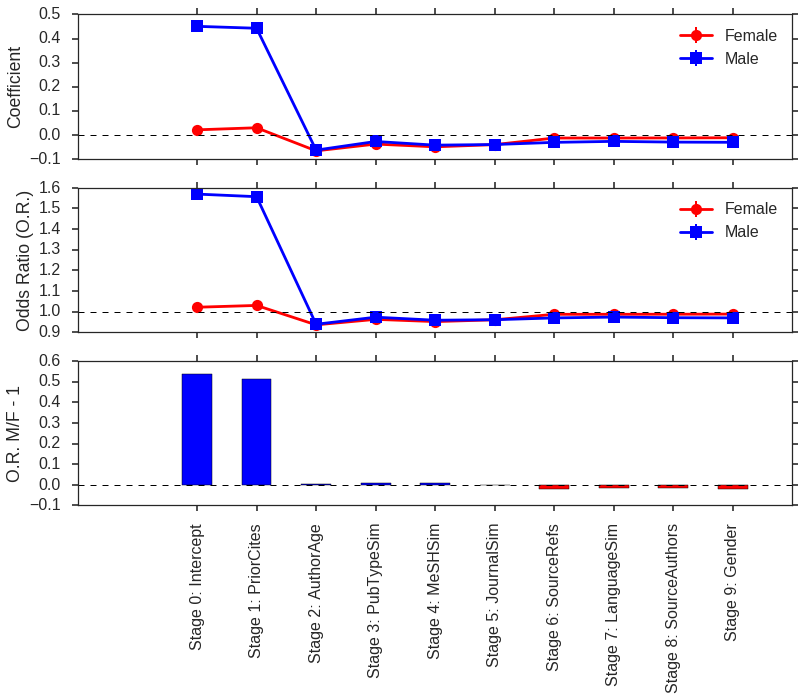

In [178]:
xticks = df_gender_coeffs.index.values
x = np.arange(xticks.shape[0])

fig, ax = plt.subplots(3,1, sharex=True)

ax[0].errorbar(x, df_gender_coeffs["C(gender, levels=GENDERS)[T.F]"],
           yerr=[
        df_gender_coeffs["C(gender, levels=GENDERS)[T.F]"] - df_gender_ci_025["C(gender, levels=GENDERS)[T.F]"], 
        df_gender_ci_975["C(gender, levels=GENDERS)[T.F]"] - df_gender_coeffs["C(gender, levels=GENDERS)[T.F]"]
                ],
           fmt="-ro", label="Female", elinewidth=2)
ax[0].errorbar(x, df_gender_coeffs["C(gender, levels=GENDERS)[T.M]"],
           yerr=[
        df_gender_coeffs["C(gender, levels=GENDERS)[T.M]"] - df_gender_ci_025["C(gender, levels=GENDERS)[T.M]"], 
        df_gender_ci_975["C(gender, levels=GENDERS)[T.M]"] - df_gender_coeffs["C(gender, levels=GENDERS)[T.M]"]
                ],
           fmt="-bs", label="Male", elinewidth=2)
ax[0].axhline(y=0.0, color="k", linestyle="--", lw=1)
ax[0].set_ylabel("Coefficient")
ax[0].legend(loc="upper right")


ax[1].errorbar(x, df_gender_coeffs["Odds Ratio Female"],
           yerr=[
        df_gender_coeffs["Odds Ratio Female"] - df_gender_ci_025["Odds Ratio Female"], 
        df_gender_ci_975["Odds Ratio Female"] - df_gender_coeffs["Odds Ratio Female"]
                ],
           fmt="-ro", label="Female", elinewidth=2)
ax[1].errorbar(x, df_gender_coeffs["Odds Ratio Male"],
           yerr=[
        df_gender_coeffs["Odds Ratio Male"] - df_gender_ci_025["Odds Ratio Male"], 
        df_gender_ci_975["Odds Ratio Male"] - df_gender_coeffs["Odds Ratio Male"]
                ],
           fmt="-bs", label="Male", elinewidth=2)
ax[1].axhline(y=1.0, color="k", linestyle="--", lw=1)
ax[1].set_ylabel("Odds Ratio (O.R.)")
ax[1].legend(loc="upper right")

bar_vals = (1./df_gender_coeffs["Odds Ratio Female/Male"]) - 1
ax[2].bar(x - 0.25, bar_vals, width=0.5, color=(bar_vals >= 0.0).map({
            True: "b",
            False: "r"
        }))
ax[2].axhline(y=0.0, color="k", linestyle="--", lw=1)
ax[2].set_ylabel("O.R. M/F - 1")
ax[2].set_xticks(x)
ax[2].set_xticklabels(xticks, rotation=90)

In [182]:
X.head().as_matrix()

array([[ 1.        ,  0.        ,  0.        ,  1.        ,  0.26666668,
         1.        ,  0.5       ,  1.32221929,  0.30103   ,  0.30103   ,
         0.60205999,  1.07918125],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.27272728,
         1.        ,  1.        ,  1.32221929,  0.47712125,  0.30103   ,
         0.60205999,  1.07918125],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.05263158,
         1.        ,  0.6666667 ,  0.90308999,  0.95424251,  2.        ,
         0.69897   ,  1.25527251],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.09090909,
         1.        ,  0.2       ,  0.90308999,  1.25527251,  2.        ,
         0.69897   ,  1.25527251],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.07142857,
         1.        ,  0.5       ,  0.90308999,  1.36172784,  2.        ,
         0.69897   ,  1.25527251]])

In [183]:
from joblib import load, dump

In [185]:
dump(X.as_matrix(), "tmp/X")

['tmp/X', 'tmp/X_01.npy']

In [186]:
dump(y.as_matrix(), "tmp/y")

['tmp/y', 'tmp/y_01.npy']

In [187]:
y.head()

,is_self_cite[False],is_self_cite[True]
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [188]:
X.columns

Index([u'Intercept', u'journal_same[T.True]',
       u'C(gender, levels=GENDERS)[T.F]', u'C(gender, levels=GENDERS)[T.M]',
       u'mesh_sim', u'lang_sim', u'pubtype_sim',
       u'np.log10(auth_prev_papers + 1)', u'np.log10(sink_prev_ncites + 1)',
       u'np.log10(source_ncites)', u'np.log10(source_n_authors)',
       u'np.log10(source_n_mesh + 1)'],
      dtype='object')

In [189]:
y.columns

Index([u'is_self_cite[False]', u'is_self_cite[True]'], dtype='object')

In [191]:
pd.DataFrame(np.random.rand(10,2), columns=["A", "B"])

,A,B
0,0.108150,0.909457
1,0.581310,0.879806
2,0.633805,0.216635
3,0.226846,0.096846
4,0.851991,0.724964
5,0.495025,0.170551
6,0.979877,0.895706
7,0.499865,0.131022
8,0.825260,0.491748
9,0.603188,0.577130


In [192]:
pd.Series(np.random.rand(10), name="y")

0    0.227641
1    0.673710
2    0.190417
3    0.568456
4    0.493430
5    0.681623
6    0.217347
7    0.799243
8    0.513595
9    0.650998
Name: y, dtype: float64

In [194]:
feature_dict.keys(), ["Intercept", TOP_FEATURE, TOP_FEATURE_2,
                         TOP_FEATURE_3, TOP_FEATURE_4, TOP_FEATURE_5,
                         TOP_FEATURE_6, TOP_FEATURE_7, TOP_FEATURE_8,
                         TOP_FEATURE_9]

(['LanguageSim',
  'PubTypeSim',
  'SourceRefs',
  'SourceMeSH',
  'JournalSim',
  'Gender',
  'SourceAuthors',
  'MeSHSim',
  'PriorCites',
  'AuthorAge'],
 ['Intercept',
  'PriorCites',
  'AuthorAge',
  'PubTypeSim',
  'MeSHSim',
  'JournalSim',
  'SourceRefs',
  'LanguageSim',
  'SourceAuthors',
  'Gender'])

In [ ]:
xticks = ['PriorCites', 'AuthorAge', 'PubTypeSim', 'MeSHSim', 'JournalSim', 'SourceRefs', 'LanguageSim',
          'SourceAuthors', 'Gender', 'SourceMeSH']
xticks_ids = dict((k,i) for i,k in enumerate(xticks))
for i, r in enumerate([results, results_2, results_3, results_4,
         results_5, results_6, results_7, results_8,
         results_9, results_10,]):
    res_dict = dict(r)
    feature_names, ll = zip(*((k, res_dict[k][0]) for k in xticks if k in res_dict))
    print "Stage %s: %s, %s" % (i, feature_names, ll)
    plt.plot(map(lambda x: xticks_ids[x], feature_names), ll, marker="s", label="Stage %s" % i)
    plt.annotate("Stage %s" % i, xy=(len(xticks), ll[-1]), xytext=((len(xticks) + 1, ll[-1])),
                arrowprops=dict(facecolor='black', shrink=0.01),)
plt.xticks(range(len(xticks)), xticks, rotation=90)
plt.ylabel("Log likelihood")
#plt.legend(loc="upper center", ncol=5)

Stage 0: ('PriorCites', 'AuthorAge', 'PubTypeSim', 'MeSHSim', 'JournalSim', 'SourceRefs', 'LanguageSim', 'SourceAuthors', 'Gender', 'SourceMeSH'), (-7416670.1357107293, -7493079.6403084444, -7898829.7948398283, -7821557.768155151, -7958515.1835050555, -8022698.1878279503, -8074155.3317323681, -8078136.1042621229, -8036083.2022255072, -8065623.0769270239)
Stage 1: ('AuthorAge', 'PubTypeSim', 'MeSHSim', 'JournalSim', 'SourceRefs', 'LanguageSim', 'SourceAuthors', 'Gender', 'SourceMeSH'), (-6806384.1392600266, -7276873.4618049841, -7251795.5990729714, -7354671.5449859686, -7399534.5621638848, -7407680.2751822127, -7416404.755436576, -7378156.2750444524, -7416558.7581201531)
Stage 2: ('PubTypeSim', 'MeSHSim', 'JournalSim', 'SourceRefs', 'LanguageSim', 'SourceAuthors', 'Gender', 'SourceMeSH'), (-6577728.4141623378, -6655368.5734106516, -6725930.3248774149, -6734001.6839056285, -6792061.2273851708, -6805737.4226387115, -6806045.2504787417, -6806336.8767548306)
Stage 3: ('MeSHSim', 'JournalSim